In [1]:
import re
import numpy as np

In [2]:
with open("./data.txt") as f:
    data = f.readlines()
    
with open("./data1.txt") as f:
    data1 = f.readlines()

In [3]:
data = data + data1
data

['begin kick: (-1693.76:-4086.46)(83.1149:509.213)\n',
 '(-1682.58:-4057.06)(202.106:763.305)11494\n',
 '(-1669.66:-4020.64)(338.109:1079.6)15901\n',
 '(-1658.34:-3987.63)(464.468:1389.63)17152\n',
 '(-1645.89:-3949.19)(581.425:1703.52)15458\n',
 '(-1636.32:-3908.68)(666.014:2007.2)17702\n',
 '(-1626.14:-3868.83)(726.977:2276.37)7093\n',
 '(-1615.18:-3822.64)(766.481:2518.96)10554\n',
 '(-1606.16:-3777.75)(788.071:2750.5)16950\n',
 '(-1598.41:-3730.65)(784.863:2956.54)15279\n',
 '(-1589.9:-3681.91)(770.816:3139.92)7969\n',
 '(-1582.6:-3627.56)(743.88:3327.77)12223\n',
 '(-1576.08:-3574.92)(706.317:3493.34)17768\n',
 '(-1571.62:-3516.08)(652.916:3668.67)11380\n',
 '(-1565.67:-3459.61)(602.558:3822.09)20081\n',
 '(-1562.2:-3398.96)(543.445:3974.38)8033\n',
 '(-1559.79:-3334.36)(477.191:4137.4)14145\n',
 '(-1557.99:-3272.82)(408.097:4275.97)12173\n',
 '(-1555.88:-3205.88)(344.563:4420.34)19462\n',
 '(-1557.54:-3136.26)(267.257:4572.82)10981\n',
 '(-1558.17:-3065.74)(193.454:4723.68)18896\

In [4]:
def parse_pos_vel(line):
    pos, vel = re.findall(r'[(](.*?)[)]', line)
    pos = list(map(float, pos.split(':')))
    vel = list(map(float, vel.split(':')))
    return (pos, vel)

def parse_timeslot(line):
    return float(re.findall(r'[0-9]*[\n]', line)[0].strip())


def preprocess(init_data):
    X = []
    Y = []
    time_feature = []
    for item in init_data:
        tmp_item = item.split()
        if tmp_item[0] == 'begin':
            # 获取原始的坐标pos=(x,y)和速度vel=(vx,vy)
            pos, vel = parse_pos_vel(tmp_item[2])
            
            # begin即初始时间戳为0
            time_slot = [0,]
            
            # 特征合并
            feature = pos + vel + time_slot # feature = [pos_x, pos_y, speed_x, speed_y, time_slot]
            
            time_feature.append(feature)
        elif tmp_item[0] == 'hit':
            # 添加最后落球点的坐标
            Y.append([last_feature[0], last_feature[1]])
            # 删除训练样本点中的最后一帧数据(落球点)
            del time_feature[-1]
            # 令训练样本点的第一帧数据(踢球点)的pos_x=0, pos_y=0
            time_feature[0][0] = 0
            time_feature[0][1] = 0
            # 将该样本点加入训练集X中
            X.append(time_feature)
            # 样本点清空
            time_feature = []
        else:
            pos, vel = parse_pos_vel(item)
            time_slot = [parse_timeslot(item) + time_feature[-1][-1]]
            feature = pos + vel + time_slot
            # pos_x, pos_y 改成相对于踢球点的坐标
            feature[0] = feature[0] - time_feature[0][0]
            feature[1] = feature[1] - time_feature[0][1]
            
            time_feature.append(feature)
            
        last_feature = feature
    return (X, Y)

In [5]:
from sklearn.utils import shuffle

def split_train_test_data(data, label):
    '''
    shuffle随机划分训练集和测试集
    '''
    n = len(data)
    n_train = int(n * 0.8)
    n_test  = n - n_train

    shuffle_data, shuffle_label = shuffle(data, label)

    training_data = shuffle_data[: n_train]
    training_label = shuffle_label[: n_train]
    testing_data = shuffle_data[n_train: ]
    testing_label = shuffle_label[n_train: ]
    
    return training_data, training_label, testing_data, testing_label 

In [6]:
def generate_data(data, label):
    '''
    从一个挑射轨迹中累次递增每5帧取出一个样本点，生成更多数据集
    '''
    new_data = []
    new_label = []
    for i in range(len(data)):
        for j in range(20, len(data[i]) + 1, 5):
            new_label.append(label[i])
            new_data.append(data[i][:j])
            
    return new_data, new_label

In [7]:
# 数据预处理，获取整体数据
X, Y = preprocess(data)

# 切分时间序列，获得更多的数据
X, Y = generate_data(X, Y)

print('total data size:', len(X))

# 划分训练集和测试集
train_X, train_Y, test_X, test_Y = split_train_test_data(X, Y)

total data size: 422


In [8]:
X

[[[0, 0, 83.1149, 509.213, 0],
  [11.180000000000064, 29.40000000000009, 202.106, 763.305, 11494.0],
  [24.09999999999991, 65.82000000000016, 338.109, 1079.6, 27395.0],
  [35.42000000000007, 98.82999999999993, 464.468, 1389.63, 44547.0],
  [47.86999999999989, 137.26999999999998, 581.425, 1703.52, 60005.0],
  [57.440000000000055, 177.7800000000002, 666.014, 2007.2, 77707.0],
  [67.61999999999989, 217.6300000000001, 726.977, 2276.37, 84800.0],
  [78.57999999999993, 263.82000000000016, 766.481, 2518.96, 95354.0],
  [87.59999999999991, 308.71000000000004, 788.071, 2750.5, 112304.0],
  [95.34999999999991, 355.80999999999995, 784.863, 2956.54, 127583.0],
  [103.8599999999999, 404.5500000000002, 770.816, 3139.92, 135552.0],
  [111.16000000000008, 458.9000000000001, 743.88, 3327.77, 147775.0],
  [117.68000000000006, 511.53999999999996, 706.317, 3493.34, 165543.0],
  [122.1400000000001, 570.3800000000001, 652.916, 3668.67, 176923.0],
  [128.08999999999992, 626.8499999999999, 602.558, 3822.09, 1

In [9]:
import torch
from torch import nn
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader
import torch.utils.data as Data

In [10]:
train_X = [torch.FloatTensor(item) for item in train_X] 
test_X = [torch.FloatTensor(item) for item in test_X]

train_X

[tensor([[ 0.0000e+00,  0.0000e+00,  8.1974e+01,  7.9384e+02,  0.0000e+00],
         [ 1.2310e+01,  4.3470e+01,  1.9297e+02,  1.0647e+03,  1.5734e+04],
         [ 2.2060e+01,  9.3720e+01,  3.0586e+02,  1.4500e+03,  3.1676e+04],
         [ 3.4160e+01,  1.3902e+02,  4.2483e+02,  1.8475e+03,  3.8712e+04],
         [ 4.4820e+01,  1.9017e+02,  5.2961e+02,  2.2559e+03,  5.0868e+04],
         [ 5.0340e+01,  2.4402e+02,  5.8177e+02,  2.6332e+03,  6.6245e+04],
         [ 5.6640e+01,  2.8910e+02,  6.0891e+02,  2.9421e+03,  8.3232e+04],
         [ 6.5950e+01,  3.4783e+02,  6.3275e+02,  3.2511e+03,  9.9370e+04],
         [ 7.2160e+01,  4.0173e+02,  6.3427e+02,  3.5068e+03,  1.1550e+05],
         [ 7.8920e+01,  4.6022e+02,  6.2484e+02,  3.7358e+03,  1.2275e+05],
         [ 8.7640e+01,  5.1340e+02,  6.2081e+02,  3.8982e+03,  1.3412e+05],
         [ 8.7760e+01,  5.7310e+02,  5.6964e+02,  4.0444e+03,  1.4889e+05],
         [ 9.2910e+01,  6.2942e+02,  5.2258e+02,  4.1487e+03,  1.6518e+05],
         [ 9

In [11]:
def _normalize(data, mean=None, std=None):
    '''
    变长时间序列tensor的正规化函数，同时对5个feature进行正规化
    并以list形式返回x,y的mean和std
    '''
    
    # 如果没有给定mean和std，则默认对数据本身求值
    if mean is None and std == None:
        # 合并tensor
        total = data[0]
        for i in range(1, len(data)):
            total = torch.cat((total, data[i]), 0)
        # 求mean和std
        mean = total.mean(dim=0)
        std = total.std(dim=0)
        
    # 正规化
    for i in range(len(data)):
        data[i] = (data[i] - mean) / std

    return mean, std

In [12]:
mean, std = _normalize(train_X)

mean_for_predict = mean[:2].numpy().tolist()
std_for_predict = std[:2].numpy().tolist()

In [13]:
_, _ = _normalize(test_X, mean, std)

In [14]:
print('train_X size:', len(train_X))
train_X  

train_X size: 337


[tensor([[ 0.2544, -0.2403,  0.0962,  0.0945, -0.9531],
         [ 0.2768, -0.2057,  0.1764,  0.1841, -0.9290],
         [ 0.2945, -0.1656,  0.2580,  0.3116, -0.9045],
         [ 0.3165, -0.1294,  0.3440,  0.4432, -0.8937],
         [ 0.3359, -0.0886,  0.4197,  0.5784, -0.8750],
         [ 0.3459, -0.0457,  0.4574,  0.7033, -0.8514],
         [ 0.3573, -0.0097,  0.4770,  0.8055, -0.8254],
         [ 0.3743,  0.0372,  0.4943,  0.9078, -0.8006],
         [ 0.3855,  0.0802,  0.4954,  0.9924, -0.7758],
         [ 0.3978,  0.1268,  0.4886,  1.0682, -0.7647],
         [ 0.4137,  0.1692,  0.4856,  1.1220, -0.7472],
         [ 0.4139,  0.2169,  0.4487,  1.1704, -0.7246],
         [ 0.4232,  0.2618,  0.4146,  1.2049, -0.6996],
         [ 0.4235,  0.3070,  0.3637,  1.2287, -0.6863],
         [ 0.4314,  0.3532,  0.3243,  1.2461, -0.6608],
         [ 0.4320,  0.4007,  0.2780,  1.2614, -0.6434],
         [ 0.4315,  0.4480,  0.2283,  1.2737, -0.6196],
         [ 0.4288,  0.4975,  0.1754,  1.2885, -0

In [15]:
print('test_X size:', len(test_X))
test_X

test_X size: 85


[tensor([[ 2.5442e-01, -2.4033e-01,  8.5255e-01, -7.8859e-01, -9.5311e-01],
         [ 2.6839e-01, -2.5152e-01,  8.1227e-01, -7.6549e-01, -9.2884e-01],
         [ 2.6868e-01, -2.5793e-01,  7.2579e-01, -7.1913e-01, -9.0780e-01],
         [ 2.6793e-01, -2.6422e-01,  6.1455e-01, -6.6149e-01, -8.8489e-01],
         [ 2.6354e-01, -2.6978e-01,  4.8796e-01, -5.9948e-01, -8.6850e-01],
         [ 2.6505e-01, -2.7787e-01,  3.7575e-01, -5.4587e-01, -8.4667e-01],
         [ 2.6248e-01, -2.8342e-01,  2.7194e-01, -4.9557e-01, -8.2758e-01],
         [ 2.6143e-01, -2.8768e-01,  1.8527e-01, -4.4816e-01, -8.0561e-01],
         [ 2.5979e-01, -2.9401e-01,  1.1501e-01, -4.1145e-01, -7.8026e-01],
         [ 2.5970e-01, -3.0057e-01,  6.4333e-02, -3.8500e-01, -7.5686e-01],
         [ 2.5881e-01, -3.0497e-01,  2.8163e-02, -3.6179e-01, -7.4328e-01],
         [ 2.5783e-01, -3.1041e-01,  3.7778e-03, -3.4505e-01, -7.2203e-01],
         [ 2.5656e-01, -3.1709e-01, -1.1916e-02, -3.3680e-01, -7.0376e-01],
         [ 2

In [16]:
print('mean for predict:', mean_for_predict)
print('std for predict:', std_for_predict)

mean for predict: [-140.009033203125, 301.2573547363281]
std for predict: [550.3173217773438, 1253.492919921875]


In [17]:
train_Y = [torch.FloatTensor([(item[0] - mean_for_predict[0]) / std_for_predict[0], (item[1] - mean_for_predict[1]) / std_for_predict[1]]) for item in train_Y]
test_Y = [torch.FloatTensor([(item[0] - mean_for_predict[0]) / std_for_predict[0], (item[1] - mean_for_predict[1]) / std_for_predict[1]]) for item in test_Y]

In [18]:
print('train_Y size:', len(train_Y))
train_Y

train_Y size: 337


[tensor([0.3960, 1.3906]),
 tensor([ 2.7280, -2.1424]),
 tensor([-1.5986,  1.4820]),
 tensor([0.9947, 3.0725]),
 tensor([-0.2711, -0.8155]),
 tensor([-0.4056,  3.0216]),
 tensor([-2.7333,  2.8622]),
 tensor([-0.9345,  2.9708]),
 tensor([-4.5128, -3.4746]),
 tensor([-3.3939,  1.5576]),
 tensor([-3.3819, -0.5689]),
 tensor([0.2093, 3.7897]),
 tensor([-1.3076,  3.3916]),
 tensor([ 0.1726, -0.3552]),
 tensor([-0.6965,  2.8731]),
 tensor([ 1.2783, -3.3864]),
 tensor([ 1.4815, -2.1876]),
 tensor([0.2093, 3.7897]),
 tensor([-3.2873,  0.1629]),
 tensor([-0.6965,  2.8731]),
 tensor([-2.7333,  2.8622]),
 tensor([0.2093, 3.7897]),
 tensor([-1.5986,  1.4820]),
 tensor([-1.5986,  1.4820]),
 tensor([3.4132, 2.7151]),
 tensor([ 1.6246, -2.6004]),
 tensor([ 3.2021, -1.1088]),
 tensor([ 0.6102, -1.9670]),
 tensor([-3.2873,  0.1629]),
 tensor([ 1.6246, -2.6004]),
 tensor([-0.6965,  2.8731]),
 tensor([-0.9345,  2.9708]),
 tensor([ 1.9327, -2.9971]),
 tensor([-1.6354,  2.2339]),
 tensor([-0.6108, -2.8705]

In [19]:
print('test_Y size:', len(test_Y))
test_Y

test_Y size: 85


[tensor([ 0.1726, -0.3552]),
 tensor([ 0.0511, -0.1081]),
 tensor([5.7752, 2.0565]),
 tensor([-1.5986,  1.4820]),
 tensor([ 3.2021, -1.1088]),
 tensor([-1.5986,  1.4820]),
 tensor([0.2093, 3.7897]),
 tensor([ 1.6246, -2.6004]),
 tensor([-1.6354,  2.2339]),
 tensor([ 1.2783, -3.3864]),
 tensor([ 1.4442, -1.4718]),
 tensor([ 5.3111, -2.4097]),
 tensor([-0.6108, -2.8705]),
 tensor([-3.2873,  0.1629]),
 tensor([ 5.3111, -2.4097]),
 tensor([ 4.2918, -0.3994]),
 tensor([-3.3939,  1.5576]),
 tensor([ 1.2527, -1.6340]),
 tensor([-1.5986,  1.4820]),
 tensor([0.3960, 1.3906]),
 tensor([ 2.7280, -2.1424]),
 tensor([-0.5723,  1.4418]),
 tensor([5.7752, 2.0565]),
 tensor([ 1.3520, -2.6243]),
 tensor([ 5.3111, -2.4097]),
 tensor([-1.5986,  1.4820]),
 tensor([ 1.3520, -2.6243]),
 tensor([3.4132, 2.7151]),
 tensor([1.1397, 1.6900]),
 tensor([ 4.2918, -0.3994]),
 tensor([5.7752, 2.0565]),
 tensor([-1.5986,  1.4820]),
 tensor([ 2.7348, -1.5160]),
 tensor([ 1.6246, -2.6004]),
 tensor([-0.4056,  3.0216]),

In [20]:
class lstm_ball(nn.Module):
    def __init__(self):
        super(lstm_ball, self).__init__()
        
        # 如果batch_first为True，输入输出数据格式是(batch, seq_len, feature)
        self.lstm = nn.LSTM(input_size = 5, hidden_size = 32, num_layers = 2, dropout = 0.2, batch_first = True)
        self.last_layer = nn.Linear(32, 2)
        self.h = None
        self.c = None
        
    def forward(self, x):
        # lstm_out 的 dimension (batch, seq_len, hidden_size)
        lstm_out, (h, c) = self.lstm(x)
        # 取用lstm最后一层的hidden state
        last_h = lstm_out[:, -1, :]
        linear_out = self.last_layer(last_h)
        
        return linear_out

In [21]:
class BallData(Data.Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return (self.data[index], self.label[index])

In [22]:
ball_data = BallData(train_X, train_Y)

In [23]:
train_loader = DataLoader(ball_data, batch_size=1, shuffle=True)

In [24]:
# 用于比较输入输出的测试程序
net = lstm_ball()
for i, (x,y) in enumerate(train_loader):
    if i == 0:
        predict = net(x)
        
        print(x.shape, y.shape, predict.shape)
        print(x)
        print(y)
        print(predict)
    else:
        break

torch.Size([1, 105, 5]) torch.Size([1, 2]) torch.Size([1, 2])
tensor([[[ 2.5442e-01, -2.4033e-01,  3.6977e-02, -1.6829e-01, -9.5311e-01],
         [ 2.9316e-01, -2.2958e-01,  6.5537e-01,  2.7498e-01, -9.2765e-01],
         [ 3.2868e-01, -2.1586e-01,  8.6723e-01,  3.8360e-01, -9.1898e-01],
         [ 3.6622e-01, -2.0444e-01,  1.0237e+00,  4.3642e-01, -8.9556e-01],
         [ 4.0511e-01, -1.9117e-01,  1.1360e+00,  4.5441e-01, -8.7501e-01],
         [ 4.3956e-01, -1.7823e-01,  1.2009e+00,  4.4816e-01, -8.4935e-01],
         [ 4.7271e-01, -1.6501e-01,  1.2277e+00,  4.2779e-01, -8.2326e-01],
         [ 5.0549e-01, -1.5240e-01,  1.2274e+00,  3.9861e-01, -8.0845e-01],
         [ 5.3901e-01, -1.3916e-01,  1.2118e+00,  3.6778e-01, -7.9012e-01],
         [ 5.6624e-01, -1.2492e-01,  1.1728e+00,  3.4080e-01, -7.6964e-01],
         [ 5.9389e-01, -1.1232e-01,  1.1233e+00,  3.1434e-01, -7.4645e-01],
         [ 6.1626e-01, -9.9288e-02,  1.0585e+00,  2.9135e-01, -7.2054e-01],
         [ 6.3374e-01, -8.

In [25]:
def loss_for_test(test_X, test_Y, net):
    '''
    手动计算MSELoss
    '''
    total_loss = 0
    
    for i in range(len(test_X)):
        # 输入需要用unsqueeze在外面套上一层维度
        predict_Y = net(test_X[i].unsqueeze(0))
        # 输出需要去掉最外层的维度
        total_loss += sum((predict_Y.squeeze() - test_Y[i])**2)
        break
        
    mseloss = total_loss / (2 * len(test_X))
    
    return mseloss
  
# # test for print
# loss = loss_for_test(test_X, test_Y, net)
# print(loss)

In [26]:
ball_net = lstm_ball()
optimizer = torch.optim.Adam(ball_net.parameters(), lr = 0.001)
loss_func = nn.MSELoss()

train_loss = []
test_loss = []

EPOCH = 50
for i in range(EPOCH):
    ball_net.train()
    for step, (x, y) in enumerate(train_loader):
        predict_y = ball_net(x)
        loss = loss_func(predict_y, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        print("train: epoch_%d  step_%d  loss=%f"%(i, step, loss.item()))
        
        loss = loss_for_test(test_X, test_Y, ball_net)
        test_loss.append(loss.item())
#         print("test:  epoch_%d  step_%d  loss=%f"%(i, step, loss.item()))

train: epoch_0  step_0  loss=2.575248
train: epoch_0  step_1  loss=8.065187
train: epoch_0  step_2  loss=5.154689
train: epoch_0  step_3  loss=3.324830
train: epoch_0  step_4  loss=1.332931
train: epoch_0  step_5  loss=5.714380
train: epoch_0  step_6  loss=6.251318
train: epoch_0  step_7  loss=16.691589
train: epoch_0  step_8  loss=2.462464
train: epoch_0  step_9  loss=4.452944
train: epoch_0  step_10  loss=1.985238
train: epoch_0  step_11  loss=1.985333
train: epoch_0  step_12  loss=2.438852
train: epoch_0  step_13  loss=2.390043
train: epoch_0  step_14  loss=4.420856
train: epoch_0  step_15  loss=5.380135
train: epoch_0  step_16  loss=2.453629
train: epoch_0  step_17  loss=4.884221
train: epoch_0  step_18  loss=6.030324
train: epoch_0  step_19  loss=2.335564
train: epoch_0  step_20  loss=7.161006
train: epoch_0  step_21  loss=4.640302
train: epoch_0  step_22  loss=4.607563
train: epoch_0  step_23  loss=5.984127
train: epoch_0  step_24  loss=2.248940
train: epoch_0  step_25  loss=3.59

train: epoch_0  step_208  loss=0.235493
train: epoch_0  step_209  loss=0.244795
train: epoch_0  step_210  loss=0.388390
train: epoch_0  step_211  loss=0.408393
train: epoch_0  step_212  loss=0.023935
train: epoch_0  step_213  loss=0.045376
train: epoch_0  step_214  loss=0.564856
train: epoch_0  step_215  loss=4.395086
train: epoch_0  step_216  loss=0.489672
train: epoch_0  step_217  loss=0.090430
train: epoch_0  step_218  loss=0.026185
train: epoch_0  step_219  loss=0.065145
train: epoch_0  step_220  loss=0.006494
train: epoch_0  step_221  loss=0.345580
train: epoch_0  step_222  loss=10.193110
train: epoch_0  step_223  loss=0.044137
train: epoch_0  step_224  loss=0.110173
train: epoch_0  step_225  loss=0.820748
train: epoch_0  step_226  loss=0.161709
train: epoch_0  step_227  loss=0.157759
train: epoch_0  step_228  loss=2.216084
train: epoch_0  step_229  loss=1.905067
train: epoch_0  step_230  loss=0.365868
train: epoch_0  step_231  loss=1.344180
train: epoch_0  step_232  loss=0.044890

train: epoch_1  step_81  loss=0.368586
train: epoch_1  step_82  loss=0.371523
train: epoch_1  step_83  loss=3.904727
train: epoch_1  step_84  loss=0.409561
train: epoch_1  step_85  loss=0.397255
train: epoch_1  step_86  loss=0.306098
train: epoch_1  step_87  loss=0.399015
train: epoch_1  step_88  loss=0.036426
train: epoch_1  step_89  loss=2.189086
train: epoch_1  step_90  loss=1.064101
train: epoch_1  step_91  loss=0.007401
train: epoch_1  step_92  loss=3.693977
train: epoch_1  step_93  loss=1.225121
train: epoch_1  step_94  loss=1.435825
train: epoch_1  step_95  loss=0.393255
train: epoch_1  step_96  loss=0.098791
train: epoch_1  step_97  loss=0.389727
train: epoch_1  step_98  loss=0.048931
train: epoch_1  step_99  loss=0.363120
train: epoch_1  step_100  loss=0.050900
train: epoch_1  step_101  loss=0.419372
train: epoch_1  step_102  loss=5.731466
train: epoch_1  step_103  loss=0.406767
train: epoch_1  step_104  loss=0.013972
train: epoch_1  step_105  loss=0.240103
train: epoch_1  ste

train: epoch_1  step_287  loss=0.124774
train: epoch_1  step_288  loss=1.027909
train: epoch_1  step_289  loss=0.009331
train: epoch_1  step_290  loss=2.161114
train: epoch_1  step_291  loss=0.324053
train: epoch_1  step_292  loss=0.372644
train: epoch_1  step_293  loss=0.009353
train: epoch_1  step_294  loss=4.464671
train: epoch_1  step_295  loss=1.394420
train: epoch_1  step_296  loss=0.526863
train: epoch_1  step_297  loss=0.153743
train: epoch_1  step_298  loss=0.867061
train: epoch_1  step_299  loss=0.430842
train: epoch_1  step_300  loss=1.544327
train: epoch_1  step_301  loss=1.718681
train: epoch_1  step_302  loss=0.127445
train: epoch_1  step_303  loss=0.316877
train: epoch_1  step_304  loss=0.171644
train: epoch_1  step_305  loss=0.929582
train: epoch_1  step_306  loss=0.515318
train: epoch_1  step_307  loss=0.649014
train: epoch_1  step_308  loss=0.480823
train: epoch_1  step_309  loss=1.426400
train: epoch_1  step_310  loss=8.816554
train: epoch_1  step_311  loss=3.541435


train: epoch_2  step_165  loss=0.014174
train: epoch_2  step_166  loss=0.151463
train: epoch_2  step_167  loss=0.963884
train: epoch_2  step_168  loss=2.939244
train: epoch_2  step_169  loss=0.312493
train: epoch_2  step_170  loss=0.070867
train: epoch_2  step_171  loss=3.288621
train: epoch_2  step_172  loss=0.244096
train: epoch_2  step_173  loss=0.421593
train: epoch_2  step_174  loss=0.299746
train: epoch_2  step_175  loss=0.675158
train: epoch_2  step_176  loss=0.788986
train: epoch_2  step_177  loss=1.058752
train: epoch_2  step_178  loss=0.008976
train: epoch_2  step_179  loss=2.968832
train: epoch_2  step_180  loss=0.359450
train: epoch_2  step_181  loss=0.127742
train: epoch_2  step_182  loss=0.657966
train: epoch_2  step_183  loss=0.000460
train: epoch_2  step_184  loss=0.020628
train: epoch_2  step_185  loss=0.031813
train: epoch_2  step_186  loss=2.288304
train: epoch_2  step_187  loss=0.056232
train: epoch_2  step_188  loss=0.160241
train: epoch_2  step_189  loss=0.246080


train: epoch_3  step_36  loss=0.015571
train: epoch_3  step_37  loss=0.416994
train: epoch_3  step_38  loss=0.001494
train: epoch_3  step_39  loss=0.003390
train: epoch_3  step_40  loss=0.020716
train: epoch_3  step_41  loss=0.205459
train: epoch_3  step_42  loss=0.533514
train: epoch_3  step_43  loss=0.586274
train: epoch_3  step_44  loss=0.084825
train: epoch_3  step_45  loss=0.020543
train: epoch_3  step_46  loss=0.105088
train: epoch_3  step_47  loss=0.149331
train: epoch_3  step_48  loss=0.134026
train: epoch_3  step_49  loss=1.507577
train: epoch_3  step_50  loss=0.537448
train: epoch_3  step_51  loss=0.733731
train: epoch_3  step_52  loss=0.304726
train: epoch_3  step_53  loss=0.038763
train: epoch_3  step_54  loss=0.157556
train: epoch_3  step_55  loss=0.174711
train: epoch_3  step_56  loss=0.295514
train: epoch_3  step_57  loss=0.244917
train: epoch_3  step_58  loss=0.071404
train: epoch_3  step_59  loss=1.142593
train: epoch_3  step_60  loss=0.059320
train: epoch_3  step_61  

train: epoch_3  step_243  loss=0.092534
train: epoch_3  step_244  loss=0.152343
train: epoch_3  step_245  loss=0.491389
train: epoch_3  step_246  loss=0.442258
train: epoch_3  step_247  loss=0.017347
train: epoch_3  step_248  loss=1.052884
train: epoch_3  step_249  loss=0.043285
train: epoch_3  step_250  loss=1.027087
train: epoch_3  step_251  loss=0.457025
train: epoch_3  step_252  loss=0.398975
train: epoch_3  step_253  loss=1.782103
train: epoch_3  step_254  loss=0.955863
train: epoch_3  step_255  loss=2.189746
train: epoch_3  step_256  loss=0.285065
train: epoch_3  step_257  loss=0.062128
train: epoch_3  step_258  loss=0.837050
train: epoch_3  step_259  loss=0.806136
train: epoch_3  step_260  loss=0.003027
train: epoch_3  step_261  loss=0.057017
train: epoch_3  step_262  loss=0.512487
train: epoch_3  step_263  loss=0.045308
train: epoch_3  step_264  loss=0.001699
train: epoch_3  step_265  loss=0.020025
train: epoch_3  step_266  loss=0.073806
train: epoch_3  step_267  loss=0.026137


train: epoch_4  step_114  loss=2.596194
train: epoch_4  step_115  loss=0.004804
train: epoch_4  step_116  loss=1.377735
train: epoch_4  step_117  loss=0.700809
train: epoch_4  step_118  loss=0.302031
train: epoch_4  step_119  loss=0.056893
train: epoch_4  step_120  loss=0.183394
train: epoch_4  step_121  loss=0.093349
train: epoch_4  step_122  loss=0.421339
train: epoch_4  step_123  loss=0.736322
train: epoch_4  step_124  loss=0.356139
train: epoch_4  step_125  loss=0.072893
train: epoch_4  step_126  loss=0.018125
train: epoch_4  step_127  loss=0.022928
train: epoch_4  step_128  loss=1.066121
train: epoch_4  step_129  loss=0.421444
train: epoch_4  step_130  loss=0.544859
train: epoch_4  step_131  loss=0.196871
train: epoch_4  step_132  loss=0.006874
train: epoch_4  step_133  loss=0.449954
train: epoch_4  step_134  loss=0.019357
train: epoch_4  step_135  loss=0.233711
train: epoch_4  step_136  loss=1.707553
train: epoch_4  step_137  loss=0.069130
train: epoch_4  step_138  loss=0.088697


train: epoch_4  step_325  loss=0.000091
train: epoch_4  step_326  loss=0.327314
train: epoch_4  step_327  loss=0.002172
train: epoch_4  step_328  loss=0.047233
train: epoch_4  step_329  loss=0.387673
train: epoch_4  step_330  loss=1.017415
train: epoch_4  step_331  loss=0.179921
train: epoch_4  step_332  loss=0.149711
train: epoch_4  step_333  loss=0.944825
train: epoch_4  step_334  loss=0.020373
train: epoch_4  step_335  loss=0.003845
train: epoch_4  step_336  loss=0.026902
train: epoch_5  step_0  loss=0.160210
train: epoch_5  step_1  loss=0.005181
train: epoch_5  step_2  loss=0.005194
train: epoch_5  step_3  loss=0.960972
train: epoch_5  step_4  loss=0.198934
train: epoch_5  step_5  loss=0.195660
train: epoch_5  step_6  loss=0.807779
train: epoch_5  step_7  loss=0.004147
train: epoch_5  step_8  loss=0.083375
train: epoch_5  step_9  loss=0.009687
train: epoch_5  step_10  loss=0.098472
train: epoch_5  step_11  loss=0.036537
train: epoch_5  step_12  loss=0.421402
train: epoch_5  step_13

train: epoch_5  step_200  loss=0.561907
train: epoch_5  step_201  loss=0.013169
train: epoch_5  step_202  loss=1.055298
train: epoch_5  step_203  loss=1.189724
train: epoch_5  step_204  loss=0.222439
train: epoch_5  step_205  loss=0.033826
train: epoch_5  step_206  loss=0.027542
train: epoch_5  step_207  loss=0.146006
train: epoch_5  step_208  loss=0.352512
train: epoch_5  step_209  loss=0.031121
train: epoch_5  step_210  loss=1.414482
train: epoch_5  step_211  loss=0.036545
train: epoch_5  step_212  loss=0.163997
train: epoch_5  step_213  loss=0.291900
train: epoch_5  step_214  loss=0.060852
train: epoch_5  step_215  loss=0.435133
train: epoch_5  step_216  loss=0.296487
train: epoch_5  step_217  loss=0.010875
train: epoch_5  step_218  loss=0.469957
train: epoch_5  step_219  loss=0.772551
train: epoch_5  step_220  loss=0.180306
train: epoch_5  step_221  loss=0.196213
train: epoch_5  step_222  loss=0.177244
train: epoch_5  step_223  loss=0.403239
train: epoch_5  step_224  loss=0.045045


train: epoch_6  step_72  loss=0.094132
train: epoch_6  step_73  loss=0.064301
train: epoch_6  step_74  loss=0.881295
train: epoch_6  step_75  loss=0.127513
train: epoch_6  step_76  loss=1.138344
train: epoch_6  step_77  loss=0.238369
train: epoch_6  step_78  loss=0.432747
train: epoch_6  step_79  loss=0.111918
train: epoch_6  step_80  loss=0.353129
train: epoch_6  step_81  loss=0.002497
train: epoch_6  step_82  loss=0.369427
train: epoch_6  step_83  loss=0.483900
train: epoch_6  step_84  loss=0.126903
train: epoch_6  step_85  loss=0.101146
train: epoch_6  step_86  loss=0.459899
train: epoch_6  step_87  loss=0.232115
train: epoch_6  step_88  loss=0.338227
train: epoch_6  step_89  loss=0.037013
train: epoch_6  step_90  loss=0.016991
train: epoch_6  step_91  loss=0.000509
train: epoch_6  step_92  loss=0.042119
train: epoch_6  step_93  loss=0.010615
train: epoch_6  step_94  loss=0.187602
train: epoch_6  step_95  loss=0.778881
train: epoch_6  step_96  loss=0.217439
train: epoch_6  step_97  

train: epoch_6  step_285  loss=0.010176
train: epoch_6  step_286  loss=0.390062
train: epoch_6  step_287  loss=0.172665
train: epoch_6  step_288  loss=1.028739
train: epoch_6  step_289  loss=1.144750
train: epoch_6  step_290  loss=0.015497
train: epoch_6  step_291  loss=0.022082
train: epoch_6  step_292  loss=0.334971
train: epoch_6  step_293  loss=0.184583
train: epoch_6  step_294  loss=0.359586
train: epoch_6  step_295  loss=0.118984
train: epoch_6  step_296  loss=0.284036
train: epoch_6  step_297  loss=0.034419
train: epoch_6  step_298  loss=0.061353
train: epoch_6  step_299  loss=0.058522
train: epoch_6  step_300  loss=0.396987
train: epoch_6  step_301  loss=0.233162
train: epoch_6  step_302  loss=0.349963
train: epoch_6  step_303  loss=1.395536
train: epoch_6  step_304  loss=0.045265
train: epoch_6  step_305  loss=0.210180
train: epoch_6  step_306  loss=0.423931
train: epoch_6  step_307  loss=0.044158
train: epoch_6  step_308  loss=1.173916
train: epoch_6  step_309  loss=0.210518


train: epoch_7  step_156  loss=0.349384
train: epoch_7  step_157  loss=0.035263
train: epoch_7  step_158  loss=0.083789
train: epoch_7  step_159  loss=0.175351
train: epoch_7  step_160  loss=0.526033
train: epoch_7  step_161  loss=0.055382
train: epoch_7  step_162  loss=0.003087
train: epoch_7  step_163  loss=0.021303
train: epoch_7  step_164  loss=0.067426
train: epoch_7  step_165  loss=0.236014
train: epoch_7  step_166  loss=0.033382
train: epoch_7  step_167  loss=0.396042
train: epoch_7  step_168  loss=0.082402
train: epoch_7  step_169  loss=0.333528
train: epoch_7  step_170  loss=0.175557
train: epoch_7  step_171  loss=0.031321
train: epoch_7  step_172  loss=0.037244
train: epoch_7  step_173  loss=0.220171
train: epoch_7  step_174  loss=0.192893
train: epoch_7  step_175  loss=0.776819
train: epoch_7  step_176  loss=0.049475
train: epoch_7  step_177  loss=0.272363
train: epoch_7  step_178  loss=0.041953
train: epoch_7  step_179  loss=0.115344
train: epoch_7  step_180  loss=0.150542


train: epoch_8  step_28  loss=0.994097
train: epoch_8  step_29  loss=0.146458
train: epoch_8  step_30  loss=0.043595
train: epoch_8  step_31  loss=0.026324
train: epoch_8  step_32  loss=0.077661
train: epoch_8  step_33  loss=0.320201
train: epoch_8  step_34  loss=0.292381
train: epoch_8  step_35  loss=0.428463
train: epoch_8  step_36  loss=0.221208
train: epoch_8  step_37  loss=0.031776
train: epoch_8  step_38  loss=0.502648
train: epoch_8  step_39  loss=0.275336
train: epoch_8  step_40  loss=1.954081
train: epoch_8  step_41  loss=0.139260
train: epoch_8  step_42  loss=0.062297
train: epoch_8  step_43  loss=0.145451
train: epoch_8  step_44  loss=1.984486
train: epoch_8  step_45  loss=0.217872
train: epoch_8  step_46  loss=0.364362
train: epoch_8  step_47  loss=0.053960
train: epoch_8  step_48  loss=0.040398
train: epoch_8  step_49  loss=0.015005
train: epoch_8  step_50  loss=0.026961
train: epoch_8  step_51  loss=1.713139
train: epoch_8  step_52  loss=0.265141
train: epoch_8  step_53  

train: epoch_8  step_239  loss=0.266733
train: epoch_8  step_240  loss=0.018041
train: epoch_8  step_241  loss=0.809637
train: epoch_8  step_242  loss=0.409201
train: epoch_8  step_243  loss=1.105892
train: epoch_8  step_244  loss=0.285932
train: epoch_8  step_245  loss=0.078314
train: epoch_8  step_246  loss=0.006267
train: epoch_8  step_247  loss=0.001855
train: epoch_8  step_248  loss=0.581423
train: epoch_8  step_249  loss=0.036345
train: epoch_8  step_250  loss=0.360615
train: epoch_8  step_251  loss=0.449050
train: epoch_8  step_252  loss=3.454603
train: epoch_8  step_253  loss=0.403200
train: epoch_8  step_254  loss=1.392435
train: epoch_8  step_255  loss=0.008593
train: epoch_8  step_256  loss=0.004718
train: epoch_8  step_257  loss=0.639451
train: epoch_8  step_258  loss=0.209575
train: epoch_8  step_259  loss=0.393412
train: epoch_8  step_260  loss=0.061935
train: epoch_8  step_261  loss=0.163257
train: epoch_8  step_262  loss=0.293026
train: epoch_8  step_263  loss=0.000511


train: epoch_9  step_114  loss=0.562261
train: epoch_9  step_115  loss=0.185916
train: epoch_9  step_116  loss=0.248291
train: epoch_9  step_117  loss=0.000224
train: epoch_9  step_118  loss=0.035081
train: epoch_9  step_119  loss=1.729181
train: epoch_9  step_120  loss=0.088576
train: epoch_9  step_121  loss=0.179136
train: epoch_9  step_122  loss=0.086720
train: epoch_9  step_123  loss=0.030158
train: epoch_9  step_124  loss=0.242954
train: epoch_9  step_125  loss=0.018615
train: epoch_9  step_126  loss=0.092230
train: epoch_9  step_127  loss=0.284879
train: epoch_9  step_128  loss=0.022381
train: epoch_9  step_129  loss=0.193428
train: epoch_9  step_130  loss=0.096676
train: epoch_9  step_131  loss=0.024905
train: epoch_9  step_132  loss=0.036907
train: epoch_9  step_133  loss=0.079007
train: epoch_9  step_134  loss=3.176571
train: epoch_9  step_135  loss=0.370155
train: epoch_9  step_136  loss=0.009369
train: epoch_9  step_137  loss=0.079500
train: epoch_9  step_138  loss=0.353848


train: epoch_9  step_321  loss=0.009019
train: epoch_9  step_322  loss=0.039881
train: epoch_9  step_323  loss=0.019367
train: epoch_9  step_324  loss=0.018602
train: epoch_9  step_325  loss=0.774057
train: epoch_9  step_326  loss=0.093617
train: epoch_9  step_327  loss=0.601784
train: epoch_9  step_328  loss=0.339461
train: epoch_9  step_329  loss=2.735826
train: epoch_9  step_330  loss=0.002069
train: epoch_9  step_331  loss=0.079985
train: epoch_9  step_332  loss=0.262684
train: epoch_9  step_333  loss=0.318284
train: epoch_9  step_334  loss=0.067694
train: epoch_9  step_335  loss=0.071329
train: epoch_9  step_336  loss=0.050030
train: epoch_10  step_0  loss=1.412462
train: epoch_10  step_1  loss=0.103368
train: epoch_10  step_2  loss=0.557897
train: epoch_10  step_3  loss=0.281502
train: epoch_10  step_4  loss=1.253556
train: epoch_10  step_5  loss=0.013048
train: epoch_10  step_6  loss=0.011432
train: epoch_10  step_7  loss=0.133103
train: epoch_10  step_8  loss=0.131078
train: ep

train: epoch_10  step_191  loss=0.022687
train: epoch_10  step_192  loss=0.012698
train: epoch_10  step_193  loss=0.029986
train: epoch_10  step_194  loss=0.000195
train: epoch_10  step_195  loss=0.022874
train: epoch_10  step_196  loss=0.753746
train: epoch_10  step_197  loss=0.046869
train: epoch_10  step_198  loss=0.049144
train: epoch_10  step_199  loss=1.526978
train: epoch_10  step_200  loss=0.194520
train: epoch_10  step_201  loss=0.017503
train: epoch_10  step_202  loss=0.205282
train: epoch_10  step_203  loss=0.051591
train: epoch_10  step_204  loss=0.004549
train: epoch_10  step_205  loss=0.296044
train: epoch_10  step_206  loss=0.030775
train: epoch_10  step_207  loss=0.118669
train: epoch_10  step_208  loss=0.490808
train: epoch_10  step_209  loss=0.009458
train: epoch_10  step_210  loss=0.052475
train: epoch_10  step_211  loss=0.285311
train: epoch_10  step_212  loss=0.852934
train: epoch_10  step_213  loss=0.038106
train: epoch_10  step_214  loss=0.204257
train: epoch_10 

train: epoch_11  step_60  loss=0.107747
train: epoch_11  step_61  loss=0.323398
train: epoch_11  step_62  loss=0.605486
train: epoch_11  step_63  loss=0.309358
train: epoch_11  step_64  loss=0.108609
train: epoch_11  step_65  loss=0.058427
train: epoch_11  step_66  loss=0.246053
train: epoch_11  step_67  loss=2.809500
train: epoch_11  step_68  loss=0.138441
train: epoch_11  step_69  loss=0.215918
train: epoch_11  step_70  loss=0.409930
train: epoch_11  step_71  loss=0.225008
train: epoch_11  step_72  loss=0.005501
train: epoch_11  step_73  loss=0.013541
train: epoch_11  step_74  loss=0.037653
train: epoch_11  step_75  loss=0.448173
train: epoch_11  step_76  loss=0.030807
train: epoch_11  step_77  loss=0.540829
train: epoch_11  step_78  loss=0.002512
train: epoch_11  step_79  loss=0.044995
train: epoch_11  step_80  loss=0.125371
train: epoch_11  step_81  loss=0.958681
train: epoch_11  step_82  loss=0.036282
train: epoch_11  step_83  loss=0.288072
train: epoch_11  step_84  loss=0.075500


train: epoch_11  step_265  loss=0.895040
train: epoch_11  step_266  loss=0.288112
train: epoch_11  step_267  loss=0.006534
train: epoch_11  step_268  loss=0.110499
train: epoch_11  step_269  loss=0.217306
train: epoch_11  step_270  loss=0.031094
train: epoch_11  step_271  loss=0.535145
train: epoch_11  step_272  loss=0.070272
train: epoch_11  step_273  loss=0.090836
train: epoch_11  step_274  loss=0.249923
train: epoch_11  step_275  loss=0.003566
train: epoch_11  step_276  loss=0.064930
train: epoch_11  step_277  loss=0.389626
train: epoch_11  step_278  loss=0.030084
train: epoch_11  step_279  loss=0.109958
train: epoch_11  step_280  loss=0.306235
train: epoch_11  step_281  loss=0.179913
train: epoch_11  step_282  loss=0.019403
train: epoch_11  step_283  loss=0.120811
train: epoch_11  step_284  loss=0.135942
train: epoch_11  step_285  loss=0.073056
train: epoch_11  step_286  loss=0.003791
train: epoch_11  step_287  loss=0.930898
train: epoch_11  step_288  loss=0.084619
train: epoch_11 

train: epoch_12  step_137  loss=0.154592
train: epoch_12  step_138  loss=0.079609
train: epoch_12  step_139  loss=0.366293
train: epoch_12  step_140  loss=0.031998
train: epoch_12  step_141  loss=0.216335
train: epoch_12  step_142  loss=0.024782
train: epoch_12  step_143  loss=2.123763
train: epoch_12  step_144  loss=2.190773
train: epoch_12  step_145  loss=0.019497
train: epoch_12  step_146  loss=0.199545
train: epoch_12  step_147  loss=0.301076
train: epoch_12  step_148  loss=0.001491
train: epoch_12  step_149  loss=0.174081
train: epoch_12  step_150  loss=0.158311
train: epoch_12  step_151  loss=0.633473
train: epoch_12  step_152  loss=0.768247
train: epoch_12  step_153  loss=0.520345
train: epoch_12  step_154  loss=0.014148
train: epoch_12  step_155  loss=0.169457
train: epoch_12  step_156  loss=0.074268
train: epoch_12  step_157  loss=0.031356
train: epoch_12  step_158  loss=0.363236
train: epoch_12  step_159  loss=0.815348
train: epoch_12  step_160  loss=0.028908
train: epoch_12 

train: epoch_13  step_3  loss=0.007694
train: epoch_13  step_4  loss=0.029998
train: epoch_13  step_5  loss=0.000073
train: epoch_13  step_6  loss=0.007226
train: epoch_13  step_7  loss=0.836171
train: epoch_13  step_8  loss=0.044493
train: epoch_13  step_9  loss=0.016336
train: epoch_13  step_10  loss=0.152752
train: epoch_13  step_11  loss=0.059874
train: epoch_13  step_12  loss=1.123797
train: epoch_13  step_13  loss=0.002622
train: epoch_13  step_14  loss=0.019391
train: epoch_13  step_15  loss=0.095350
train: epoch_13  step_16  loss=0.615816
train: epoch_13  step_17  loss=0.216589
train: epoch_13  step_18  loss=1.930463
train: epoch_13  step_19  loss=0.067864
train: epoch_13  step_20  loss=0.039230
train: epoch_13  step_21  loss=0.111148
train: epoch_13  step_22  loss=0.133744
train: epoch_13  step_23  loss=0.391837
train: epoch_13  step_24  loss=0.336779
train: epoch_13  step_25  loss=0.625882
train: epoch_13  step_26  loss=0.003496
train: epoch_13  step_27  loss=0.162873
train: 

train: epoch_13  step_209  loss=0.068191
train: epoch_13  step_210  loss=0.062193
train: epoch_13  step_211  loss=0.530217
train: epoch_13  step_212  loss=0.042883
train: epoch_13  step_213  loss=0.038397
train: epoch_13  step_214  loss=0.409937
train: epoch_13  step_215  loss=0.436064
train: epoch_13  step_216  loss=0.009216
train: epoch_13  step_217  loss=0.103869
train: epoch_13  step_218  loss=0.121743
train: epoch_13  step_219  loss=0.020116
train: epoch_13  step_220  loss=0.135142
train: epoch_13  step_221  loss=0.000805
train: epoch_13  step_222  loss=0.051486
train: epoch_13  step_223  loss=0.860153
train: epoch_13  step_224  loss=0.418731
train: epoch_13  step_225  loss=0.092678
train: epoch_13  step_226  loss=0.080333
train: epoch_13  step_227  loss=1.019967
train: epoch_13  step_228  loss=1.480655
train: epoch_13  step_229  loss=1.326795
train: epoch_13  step_230  loss=0.027183
train: epoch_13  step_231  loss=0.279198
train: epoch_13  step_232  loss=0.019060
train: epoch_13 

train: epoch_14  step_74  loss=0.000420
train: epoch_14  step_75  loss=0.343775
train: epoch_14  step_76  loss=0.632288
train: epoch_14  step_77  loss=0.111210
train: epoch_14  step_78  loss=0.000221
train: epoch_14  step_79  loss=0.013851
train: epoch_14  step_80  loss=0.163865
train: epoch_14  step_81  loss=0.021974
train: epoch_14  step_82  loss=0.094266
train: epoch_14  step_83  loss=0.078832
train: epoch_14  step_84  loss=0.813138
train: epoch_14  step_85  loss=0.163337
train: epoch_14  step_86  loss=0.589160
train: epoch_14  step_87  loss=0.137549
train: epoch_14  step_88  loss=0.390006
train: epoch_14  step_89  loss=0.942286
train: epoch_14  step_90  loss=0.633864
train: epoch_14  step_91  loss=0.023632
train: epoch_14  step_92  loss=0.093413
train: epoch_14  step_93  loss=0.008792
train: epoch_14  step_94  loss=0.033652
train: epoch_14  step_95  loss=0.152177
train: epoch_14  step_96  loss=0.099867
train: epoch_14  step_97  loss=0.023347
train: epoch_14  step_98  loss=0.911182


train: epoch_14  step_278  loss=0.444874
train: epoch_14  step_279  loss=0.540023
train: epoch_14  step_280  loss=0.802019
train: epoch_14  step_281  loss=0.174272
train: epoch_14  step_282  loss=0.779007
train: epoch_14  step_283  loss=1.365747
train: epoch_14  step_284  loss=1.642980
train: epoch_14  step_285  loss=0.178510
train: epoch_14  step_286  loss=0.366137
train: epoch_14  step_287  loss=0.242283
train: epoch_14  step_288  loss=0.074120
train: epoch_14  step_289  loss=0.001182
train: epoch_14  step_290  loss=0.067134
train: epoch_14  step_291  loss=0.011412
train: epoch_14  step_292  loss=0.009745
train: epoch_14  step_293  loss=0.003175
train: epoch_14  step_294  loss=0.082818
train: epoch_14  step_295  loss=0.020986
train: epoch_14  step_296  loss=0.132965
train: epoch_14  step_297  loss=0.084888
train: epoch_14  step_298  loss=0.365606
train: epoch_14  step_299  loss=0.293763
train: epoch_14  step_300  loss=1.334978
train: epoch_14  step_301  loss=0.194245
train: epoch_14 

train: epoch_15  step_145  loss=0.015611
train: epoch_15  step_146  loss=0.024667
train: epoch_15  step_147  loss=0.014279
train: epoch_15  step_148  loss=0.022815
train: epoch_15  step_149  loss=0.211784
train: epoch_15  step_150  loss=0.036405
train: epoch_15  step_151  loss=0.005213
train: epoch_15  step_152  loss=0.700054
train: epoch_15  step_153  loss=0.048215
train: epoch_15  step_154  loss=0.006147
train: epoch_15  step_155  loss=0.044068
train: epoch_15  step_156  loss=0.315719
train: epoch_15  step_157  loss=0.004951
train: epoch_15  step_158  loss=0.172042
train: epoch_15  step_159  loss=0.048130
train: epoch_15  step_160  loss=0.721488
train: epoch_15  step_161  loss=0.077788
train: epoch_15  step_162  loss=0.044162
train: epoch_15  step_163  loss=0.494420
train: epoch_15  step_164  loss=0.023042
train: epoch_15  step_165  loss=0.138770
train: epoch_15  step_166  loss=0.017163
train: epoch_15  step_167  loss=0.779386
train: epoch_15  step_168  loss=0.026947
train: epoch_15 

train: epoch_16  step_12  loss=0.005893
train: epoch_16  step_13  loss=0.981221
train: epoch_16  step_14  loss=0.072736
train: epoch_16  step_15  loss=0.021769
train: epoch_16  step_16  loss=0.018557
train: epoch_16  step_17  loss=0.001062
train: epoch_16  step_18  loss=0.088053
train: epoch_16  step_19  loss=0.390000
train: epoch_16  step_20  loss=0.584484
train: epoch_16  step_21  loss=0.802393
train: epoch_16  step_22  loss=0.052460
train: epoch_16  step_23  loss=0.056127
train: epoch_16  step_24  loss=0.008620
train: epoch_16  step_25  loss=0.039281
train: epoch_16  step_26  loss=0.006230
train: epoch_16  step_27  loss=0.286985
train: epoch_16  step_28  loss=0.081641
train: epoch_16  step_29  loss=0.005953
train: epoch_16  step_30  loss=0.095852
train: epoch_16  step_31  loss=1.725525
train: epoch_16  step_32  loss=0.291072
train: epoch_16  step_33  loss=0.068134
train: epoch_16  step_34  loss=0.008643
train: epoch_16  step_35  loss=0.049041
train: epoch_16  step_36  loss=0.147362


train: epoch_16  step_219  loss=0.163453
train: epoch_16  step_220  loss=0.002344
train: epoch_16  step_221  loss=0.085885
train: epoch_16  step_222  loss=0.179225
train: epoch_16  step_223  loss=0.203641
train: epoch_16  step_224  loss=0.066196
train: epoch_16  step_225  loss=1.137547
train: epoch_16  step_226  loss=0.019081
train: epoch_16  step_227  loss=0.019110
train: epoch_16  step_228  loss=0.045195
train: epoch_16  step_229  loss=0.017399
train: epoch_16  step_230  loss=0.019132
train: epoch_16  step_231  loss=0.120586
train: epoch_16  step_232  loss=3.615718
train: epoch_16  step_233  loss=0.879248
train: epoch_16  step_234  loss=0.422301
train: epoch_16  step_235  loss=0.206138
train: epoch_16  step_236  loss=0.027612
train: epoch_16  step_237  loss=0.679070
train: epoch_16  step_238  loss=0.263057
train: epoch_16  step_239  loss=0.694476
train: epoch_16  step_240  loss=0.552211
train: epoch_16  step_241  loss=0.340991
train: epoch_16  step_242  loss=0.009643
train: epoch_16 

train: epoch_17  step_89  loss=0.140049
train: epoch_17  step_90  loss=0.210332
train: epoch_17  step_91  loss=0.004378
train: epoch_17  step_92  loss=1.774769
train: epoch_17  step_93  loss=0.037440
train: epoch_17  step_94  loss=0.597072
train: epoch_17  step_95  loss=0.101980
train: epoch_17  step_96  loss=1.652178
train: epoch_17  step_97  loss=0.296851
train: epoch_17  step_98  loss=0.073678
train: epoch_17  step_99  loss=0.199995
train: epoch_17  step_100  loss=0.161525
train: epoch_17  step_101  loss=0.036641
train: epoch_17  step_102  loss=0.012131
train: epoch_17  step_103  loss=0.345914
train: epoch_17  step_104  loss=0.071694
train: epoch_17  step_105  loss=0.001661
train: epoch_17  step_106  loss=0.127433
train: epoch_17  step_107  loss=0.152952
train: epoch_17  step_108  loss=0.006754
train: epoch_17  step_109  loss=0.024776
train: epoch_17  step_110  loss=0.057953
train: epoch_17  step_111  loss=0.051052
train: epoch_17  step_112  loss=0.040135
train: epoch_17  step_113  

train: epoch_17  step_294  loss=0.048030
train: epoch_17  step_295  loss=2.849962
train: epoch_17  step_296  loss=0.124024
train: epoch_17  step_297  loss=0.144905
train: epoch_17  step_298  loss=0.030939
train: epoch_17  step_299  loss=0.021805
train: epoch_17  step_300  loss=1.314189
train: epoch_17  step_301  loss=0.097347
train: epoch_17  step_302  loss=0.047357
train: epoch_17  step_303  loss=0.035164
train: epoch_17  step_304  loss=0.354719
train: epoch_17  step_305  loss=0.550051
train: epoch_17  step_306  loss=0.004417
train: epoch_17  step_307  loss=0.512809
train: epoch_17  step_308  loss=0.030643
train: epoch_17  step_309  loss=0.057575
train: epoch_17  step_310  loss=0.005474
train: epoch_17  step_311  loss=0.021301
train: epoch_17  step_312  loss=0.724389
train: epoch_17  step_313  loss=0.022977
train: epoch_17  step_314  loss=1.091486
train: epoch_17  step_315  loss=0.012841
train: epoch_17  step_316  loss=0.095735
train: epoch_17  step_317  loss=0.393769
train: epoch_17 

train: epoch_18  step_164  loss=0.028406
train: epoch_18  step_165  loss=0.266316
train: epoch_18  step_166  loss=0.056080
train: epoch_18  step_167  loss=0.232515
train: epoch_18  step_168  loss=0.215257
train: epoch_18  step_169  loss=0.012202
train: epoch_18  step_170  loss=0.017593
train: epoch_18  step_171  loss=0.047329
train: epoch_18  step_172  loss=0.181394
train: epoch_18  step_173  loss=0.126261
train: epoch_18  step_174  loss=0.007643
train: epoch_18  step_175  loss=0.030722
train: epoch_18  step_176  loss=0.023460
train: epoch_18  step_177  loss=0.237490
train: epoch_18  step_178  loss=0.022876
train: epoch_18  step_179  loss=0.047166
train: epoch_18  step_180  loss=0.034280
train: epoch_18  step_181  loss=0.157762
train: epoch_18  step_182  loss=0.011524
train: epoch_18  step_183  loss=0.067561
train: epoch_18  step_184  loss=0.142747
train: epoch_18  step_185  loss=0.168408
train: epoch_18  step_186  loss=0.018914
train: epoch_18  step_187  loss=0.030723
train: epoch_18 

train: epoch_19  step_29  loss=1.788264
train: epoch_19  step_30  loss=0.218565
train: epoch_19  step_31  loss=0.026670
train: epoch_19  step_32  loss=0.382116
train: epoch_19  step_33  loss=0.179361
train: epoch_19  step_34  loss=0.060823
train: epoch_19  step_35  loss=0.055996
train: epoch_19  step_36  loss=0.079811
train: epoch_19  step_37  loss=0.014766
train: epoch_19  step_38  loss=0.373863
train: epoch_19  step_39  loss=0.171356
train: epoch_19  step_40  loss=0.018531
train: epoch_19  step_41  loss=0.421040
train: epoch_19  step_42  loss=0.012535
train: epoch_19  step_43  loss=0.014910
train: epoch_19  step_44  loss=0.035420
train: epoch_19  step_45  loss=0.067277
train: epoch_19  step_46  loss=0.423263
train: epoch_19  step_47  loss=0.750555
train: epoch_19  step_48  loss=0.002655
train: epoch_19  step_49  loss=0.008665
train: epoch_19  step_50  loss=0.323363
train: epoch_19  step_51  loss=0.085201
train: epoch_19  step_52  loss=1.376796
train: epoch_19  step_53  loss=1.937804


train: epoch_19  step_237  loss=0.143216
train: epoch_19  step_238  loss=0.171373
train: epoch_19  step_239  loss=0.022018
train: epoch_19  step_240  loss=0.006246
train: epoch_19  step_241  loss=0.454604
train: epoch_19  step_242  loss=0.096810
train: epoch_19  step_243  loss=0.060091
train: epoch_19  step_244  loss=0.048162
train: epoch_19  step_245  loss=0.123122
train: epoch_19  step_246  loss=0.129589
train: epoch_19  step_247  loss=0.072139
train: epoch_19  step_248  loss=0.009706
train: epoch_19  step_249  loss=0.069392
train: epoch_19  step_250  loss=0.007932
train: epoch_19  step_251  loss=0.026072
train: epoch_19  step_252  loss=0.024169
train: epoch_19  step_253  loss=1.109395
train: epoch_19  step_254  loss=0.167518
train: epoch_19  step_255  loss=0.093984
train: epoch_19  step_256  loss=0.132039
train: epoch_19  step_257  loss=0.022712
train: epoch_19  step_258  loss=0.179430
train: epoch_19  step_259  loss=0.123814
train: epoch_19  step_260  loss=0.079832
train: epoch_19 

train: epoch_20  step_109  loss=0.055557
train: epoch_20  step_110  loss=0.224652
train: epoch_20  step_111  loss=0.164115
train: epoch_20  step_112  loss=0.476537
train: epoch_20  step_113  loss=0.002609
train: epoch_20  step_114  loss=0.552880
train: epoch_20  step_115  loss=0.044899
train: epoch_20  step_116  loss=0.000011
train: epoch_20  step_117  loss=0.000434
train: epoch_20  step_118  loss=0.003208
train: epoch_20  step_119  loss=0.030685
train: epoch_20  step_120  loss=0.063919
train: epoch_20  step_121  loss=0.008209
train: epoch_20  step_122  loss=0.054221
train: epoch_20  step_123  loss=0.016213
train: epoch_20  step_124  loss=0.028820
train: epoch_20  step_125  loss=0.012361
train: epoch_20  step_126  loss=0.314412
train: epoch_20  step_127  loss=0.050267
train: epoch_20  step_128  loss=0.124093
train: epoch_20  step_129  loss=1.918255
train: epoch_20  step_130  loss=0.118110
train: epoch_20  step_131  loss=0.002882
train: epoch_20  step_132  loss=0.032941
train: epoch_20 

train: epoch_20  step_313  loss=0.009075
train: epoch_20  step_314  loss=0.041829
train: epoch_20  step_315  loss=0.590448
train: epoch_20  step_316  loss=0.485898
train: epoch_20  step_317  loss=0.000946
train: epoch_20  step_318  loss=0.013329
train: epoch_20  step_319  loss=0.006331
train: epoch_20  step_320  loss=0.322220
train: epoch_20  step_321  loss=0.498273
train: epoch_20  step_322  loss=0.311668
train: epoch_20  step_323  loss=0.334552
train: epoch_20  step_324  loss=0.027839
train: epoch_20  step_325  loss=0.082492
train: epoch_20  step_326  loss=0.004996
train: epoch_20  step_327  loss=0.028814
train: epoch_20  step_328  loss=0.971096
train: epoch_20  step_329  loss=0.175128
train: epoch_20  step_330  loss=0.558466
train: epoch_20  step_331  loss=0.025155
train: epoch_20  step_332  loss=0.008240
train: epoch_20  step_333  loss=0.000420
train: epoch_20  step_334  loss=0.731772
train: epoch_20  step_335  loss=0.036974
train: epoch_20  step_336  loss=0.029010
train: epoch_21 

train: epoch_21  step_180  loss=0.157996
train: epoch_21  step_181  loss=0.941751
train: epoch_21  step_182  loss=0.269052
train: epoch_21  step_183  loss=0.014276
train: epoch_21  step_184  loss=0.011968
train: epoch_21  step_185  loss=0.119542
train: epoch_21  step_186  loss=0.020470
train: epoch_21  step_187  loss=0.387997
train: epoch_21  step_188  loss=0.016322
train: epoch_21  step_189  loss=0.115394
train: epoch_21  step_190  loss=0.071211
train: epoch_21  step_191  loss=0.046705
train: epoch_21  step_192  loss=0.066800
train: epoch_21  step_193  loss=0.445481
train: epoch_21  step_194  loss=0.412105
train: epoch_21  step_195  loss=0.031707
train: epoch_21  step_196  loss=0.208398
train: epoch_21  step_197  loss=0.137141
train: epoch_21  step_198  loss=0.003925
train: epoch_21  step_199  loss=0.229026
train: epoch_21  step_200  loss=0.312067
train: epoch_21  step_201  loss=0.934955
train: epoch_21  step_202  loss=0.007431
train: epoch_21  step_203  loss=0.015542
train: epoch_21 

train: epoch_22  step_48  loss=0.057298
train: epoch_22  step_49  loss=0.243887
train: epoch_22  step_50  loss=0.072702
train: epoch_22  step_51  loss=0.025675
train: epoch_22  step_52  loss=0.486149
train: epoch_22  step_53  loss=0.980106
train: epoch_22  step_54  loss=0.003767
train: epoch_22  step_55  loss=0.378391
train: epoch_22  step_56  loss=0.007368
train: epoch_22  step_57  loss=0.007509
train: epoch_22  step_58  loss=0.365868
train: epoch_22  step_59  loss=0.171291
train: epoch_22  step_60  loss=0.262454
train: epoch_22  step_61  loss=0.070882
train: epoch_22  step_62  loss=0.215303
train: epoch_22  step_63  loss=0.071946
train: epoch_22  step_64  loss=0.010415
train: epoch_22  step_65  loss=0.054651
train: epoch_22  step_66  loss=0.038019
train: epoch_22  step_67  loss=0.054608
train: epoch_22  step_68  loss=0.030800
train: epoch_22  step_69  loss=0.025424
train: epoch_22  step_70  loss=0.152835
train: epoch_22  step_71  loss=0.144540
train: epoch_22  step_72  loss=0.019417


train: epoch_22  step_255  loss=0.005359
train: epoch_22  step_256  loss=0.147087
train: epoch_22  step_257  loss=0.086231
train: epoch_22  step_258  loss=0.073087
train: epoch_22  step_259  loss=0.025312
train: epoch_22  step_260  loss=0.043961
train: epoch_22  step_261  loss=2.270787
train: epoch_22  step_262  loss=0.008003
train: epoch_22  step_263  loss=0.099054
train: epoch_22  step_264  loss=0.010088
train: epoch_22  step_265  loss=0.001689
train: epoch_22  step_266  loss=0.001189
train: epoch_22  step_267  loss=0.006875
train: epoch_22  step_268  loss=0.185292
train: epoch_22  step_269  loss=0.003172
train: epoch_22  step_270  loss=0.009924
train: epoch_22  step_271  loss=0.086908
train: epoch_22  step_272  loss=0.262806
train: epoch_22  step_273  loss=0.003423
train: epoch_22  step_274  loss=0.018343
train: epoch_22  step_275  loss=0.737902
train: epoch_22  step_276  loss=0.014593
train: epoch_22  step_277  loss=0.161762
train: epoch_22  step_278  loss=0.317561
train: epoch_22 

train: epoch_23  step_126  loss=0.182324
train: epoch_23  step_127  loss=0.277214
train: epoch_23  step_128  loss=0.303021
train: epoch_23  step_129  loss=0.893974
train: epoch_23  step_130  loss=0.004193
train: epoch_23  step_131  loss=0.002394
train: epoch_23  step_132  loss=0.011251
train: epoch_23  step_133  loss=0.106891
train: epoch_23  step_134  loss=0.145262
train: epoch_23  step_135  loss=0.041125
train: epoch_23  step_136  loss=0.008227
train: epoch_23  step_137  loss=0.206014
train: epoch_23  step_138  loss=2.353408
train: epoch_23  step_139  loss=0.004046
train: epoch_23  step_140  loss=0.176011
train: epoch_23  step_141  loss=0.598281
train: epoch_23  step_142  loss=0.022169
train: epoch_23  step_143  loss=0.279122
train: epoch_23  step_144  loss=0.184066
train: epoch_23  step_145  loss=0.017656
train: epoch_23  step_146  loss=0.160016
train: epoch_23  step_147  loss=0.144847
train: epoch_23  step_148  loss=2.669973
train: epoch_23  step_149  loss=0.030125
train: epoch_23 

train: epoch_23  step_326  loss=0.164267
train: epoch_23  step_327  loss=0.616435
train: epoch_23  step_328  loss=0.031086
train: epoch_23  step_329  loss=0.003371
train: epoch_23  step_330  loss=0.182214
train: epoch_23  step_331  loss=0.019696
train: epoch_23  step_332  loss=0.090405
train: epoch_23  step_333  loss=0.643262
train: epoch_23  step_334  loss=0.409607
train: epoch_23  step_335  loss=0.418238
train: epoch_23  step_336  loss=0.003336
train: epoch_24  step_0  loss=0.518573
train: epoch_24  step_1  loss=0.087051
train: epoch_24  step_2  loss=0.219621
train: epoch_24  step_3  loss=0.047788
train: epoch_24  step_4  loss=1.036754
train: epoch_24  step_5  loss=0.256807
train: epoch_24  step_6  loss=0.016827
train: epoch_24  step_7  loss=0.027673
train: epoch_24  step_8  loss=0.055392
train: epoch_24  step_9  loss=0.045268
train: epoch_24  step_10  loss=0.017652
train: epoch_24  step_11  loss=0.060630
train: epoch_24  step_12  loss=0.229723
train: epoch_24  step_13  loss=0.073885

train: epoch_24  step_193  loss=0.188675
train: epoch_24  step_194  loss=0.332213
train: epoch_24  step_195  loss=0.348037
train: epoch_24  step_196  loss=0.041975
train: epoch_24  step_197  loss=0.174679
train: epoch_24  step_198  loss=0.072784
train: epoch_24  step_199  loss=0.018676
train: epoch_24  step_200  loss=0.012989
train: epoch_24  step_201  loss=0.276821
train: epoch_24  step_202  loss=0.169892
train: epoch_24  step_203  loss=0.338889
train: epoch_24  step_204  loss=0.020108
train: epoch_24  step_205  loss=0.032899
train: epoch_24  step_206  loss=0.020179
train: epoch_24  step_207  loss=0.507886
train: epoch_24  step_208  loss=0.419055
train: epoch_24  step_209  loss=0.493110
train: epoch_24  step_210  loss=0.004566
train: epoch_24  step_211  loss=0.006990
train: epoch_24  step_212  loss=0.796372
train: epoch_24  step_213  loss=0.034023
train: epoch_24  step_214  loss=0.431574
train: epoch_24  step_215  loss=0.015726
train: epoch_24  step_216  loss=0.069942
train: epoch_24 

train: epoch_25  step_59  loss=0.004393
train: epoch_25  step_60  loss=0.055854
train: epoch_25  step_61  loss=0.067586
train: epoch_25  step_62  loss=0.064990
train: epoch_25  step_63  loss=0.265970
train: epoch_25  step_64  loss=0.095821
train: epoch_25  step_65  loss=0.005296
train: epoch_25  step_66  loss=0.109616
train: epoch_25  step_67  loss=0.244807
train: epoch_25  step_68  loss=0.018934
train: epoch_25  step_69  loss=0.006204
train: epoch_25  step_70  loss=0.050010
train: epoch_25  step_71  loss=0.143508
train: epoch_25  step_72  loss=0.001379
train: epoch_25  step_73  loss=0.032371
train: epoch_25  step_74  loss=0.077635
train: epoch_25  step_75  loss=0.038347
train: epoch_25  step_76  loss=0.124789
train: epoch_25  step_77  loss=0.993318
train: epoch_25  step_78  loss=0.002546
train: epoch_25  step_79  loss=0.144992
train: epoch_25  step_80  loss=0.047540
train: epoch_25  step_81  loss=0.184626
train: epoch_25  step_82  loss=0.034938
train: epoch_25  step_83  loss=0.223693


train: epoch_25  step_268  loss=0.205331
train: epoch_25  step_269  loss=0.181593
train: epoch_25  step_270  loss=0.000562
train: epoch_25  step_271  loss=0.013426
train: epoch_25  step_272  loss=0.098411
train: epoch_25  step_273  loss=0.058824
train: epoch_25  step_274  loss=0.196973
train: epoch_25  step_275  loss=0.011405
train: epoch_25  step_276  loss=0.053887
train: epoch_25  step_277  loss=0.132982
train: epoch_25  step_278  loss=0.009800
train: epoch_25  step_279  loss=0.072153
train: epoch_25  step_280  loss=0.124092
train: epoch_25  step_281  loss=0.157204
train: epoch_25  step_282  loss=0.004691
train: epoch_25  step_283  loss=0.321665
train: epoch_25  step_284  loss=0.111244
train: epoch_25  step_285  loss=1.834641
train: epoch_25  step_286  loss=0.025458
train: epoch_25  step_287  loss=0.031416
train: epoch_25  step_288  loss=0.093593
train: epoch_25  step_289  loss=0.046472
train: epoch_25  step_290  loss=0.129084
train: epoch_25  step_291  loss=0.008449
train: epoch_25 

train: epoch_26  step_135  loss=0.071995
train: epoch_26  step_136  loss=0.198512
train: epoch_26  step_137  loss=0.045582
train: epoch_26  step_138  loss=0.058969
train: epoch_26  step_139  loss=0.181372
train: epoch_26  step_140  loss=0.049439
train: epoch_26  step_141  loss=0.024048
train: epoch_26  step_142  loss=0.075951
train: epoch_26  step_143  loss=0.013623
train: epoch_26  step_144  loss=0.030875
train: epoch_26  step_145  loss=0.002141
train: epoch_26  step_146  loss=0.017178
train: epoch_26  step_147  loss=0.202845
train: epoch_26  step_148  loss=1.030020
train: epoch_26  step_149  loss=0.144268
train: epoch_26  step_150  loss=0.264768
train: epoch_26  step_151  loss=0.334142
train: epoch_26  step_152  loss=0.158560
train: epoch_26  step_153  loss=0.009222
train: epoch_26  step_154  loss=0.138631
train: epoch_26  step_155  loss=0.022189
train: epoch_26  step_156  loss=0.432203
train: epoch_26  step_157  loss=0.018889
train: epoch_26  step_158  loss=0.367455
train: epoch_26 

train: epoch_27  step_6  loss=0.051792
train: epoch_27  step_7  loss=1.379635
train: epoch_27  step_8  loss=0.102011
train: epoch_27  step_9  loss=3.023722
train: epoch_27  step_10  loss=0.268007
train: epoch_27  step_11  loss=0.482207
train: epoch_27  step_12  loss=0.125561
train: epoch_27  step_13  loss=0.010295
train: epoch_27  step_14  loss=0.154409
train: epoch_27  step_15  loss=2.528228
train: epoch_27  step_16  loss=0.146334
train: epoch_27  step_17  loss=0.004569
train: epoch_27  step_18  loss=0.196440
train: epoch_27  step_19  loss=0.000313
train: epoch_27  step_20  loss=0.001442
train: epoch_27  step_21  loss=0.007033
train: epoch_27  step_22  loss=0.049981
train: epoch_27  step_23  loss=0.049580
train: epoch_27  step_24  loss=0.002968
train: epoch_27  step_25  loss=0.011500
train: epoch_27  step_26  loss=0.762539
train: epoch_27  step_27  loss=0.371814
train: epoch_27  step_28  loss=0.268518
train: epoch_27  step_29  loss=0.000685
train: epoch_27  step_30  loss=0.222869
trai

train: epoch_27  step_214  loss=0.002839
train: epoch_27  step_215  loss=0.008284
train: epoch_27  step_216  loss=0.294226
train: epoch_27  step_217  loss=0.013699
train: epoch_27  step_218  loss=0.119838
train: epoch_27  step_219  loss=0.072947
train: epoch_27  step_220  loss=0.061222
train: epoch_27  step_221  loss=0.003757
train: epoch_27  step_222  loss=0.500575
train: epoch_27  step_223  loss=0.007286
train: epoch_27  step_224  loss=0.025519
train: epoch_27  step_225  loss=0.053451
train: epoch_27  step_226  loss=0.000558
train: epoch_27  step_227  loss=0.142998
train: epoch_27  step_228  loss=0.017967
train: epoch_27  step_229  loss=0.002466
train: epoch_27  step_230  loss=0.119981
train: epoch_27  step_231  loss=0.012227
train: epoch_27  step_232  loss=0.071455
train: epoch_27  step_233  loss=0.004411
train: epoch_27  step_234  loss=0.647892
train: epoch_27  step_235  loss=0.032746
train: epoch_27  step_236  loss=0.063760
train: epoch_27  step_237  loss=0.017688
train: epoch_27 

train: epoch_28  step_86  loss=0.157685
train: epoch_28  step_87  loss=0.000292
train: epoch_28  step_88  loss=0.046352
train: epoch_28  step_89  loss=0.160033
train: epoch_28  step_90  loss=0.268958
train: epoch_28  step_91  loss=0.029733
train: epoch_28  step_92  loss=0.069725
train: epoch_28  step_93  loss=0.005434
train: epoch_28  step_94  loss=0.004374
train: epoch_28  step_95  loss=0.161196
train: epoch_28  step_96  loss=0.559179
train: epoch_28  step_97  loss=0.002728
train: epoch_28  step_98  loss=0.347312
train: epoch_28  step_99  loss=0.267128
train: epoch_28  step_100  loss=0.520762
train: epoch_28  step_101  loss=0.067479
train: epoch_28  step_102  loss=0.006464
train: epoch_28  step_103  loss=0.002888
train: epoch_28  step_104  loss=0.020071
train: epoch_28  step_105  loss=0.248621
train: epoch_28  step_106  loss=0.313089
train: epoch_28  step_107  loss=0.382254
train: epoch_28  step_108  loss=0.047460
train: epoch_28  step_109  loss=0.008122
train: epoch_28  step_110  los

train: epoch_28  step_292  loss=0.006657
train: epoch_28  step_293  loss=0.154685
train: epoch_28  step_294  loss=0.292371
train: epoch_28  step_295  loss=0.000848
train: epoch_28  step_296  loss=0.064126
train: epoch_28  step_297  loss=0.041030
train: epoch_28  step_298  loss=0.002772
train: epoch_28  step_299  loss=0.031689
train: epoch_28  step_300  loss=0.009100
train: epoch_28  step_301  loss=0.107501
train: epoch_28  step_302  loss=0.016038
train: epoch_28  step_303  loss=0.033521
train: epoch_28  step_304  loss=0.117209
train: epoch_28  step_305  loss=0.113484
train: epoch_28  step_306  loss=0.000647
train: epoch_28  step_307  loss=0.134898
train: epoch_28  step_308  loss=0.124043
train: epoch_28  step_309  loss=0.016253
train: epoch_28  step_310  loss=0.180686
train: epoch_28  step_311  loss=0.447649
train: epoch_28  step_312  loss=0.010655
train: epoch_28  step_313  loss=0.127158
train: epoch_28  step_314  loss=3.313110
train: epoch_28  step_315  loss=0.855874
train: epoch_28 

train: epoch_29  step_159  loss=0.003295
train: epoch_29  step_160  loss=0.464856
train: epoch_29  step_161  loss=0.307262
train: epoch_29  step_162  loss=0.212150
train: epoch_29  step_163  loss=0.070816
train: epoch_29  step_164  loss=0.009756
train: epoch_29  step_165  loss=0.004192
train: epoch_29  step_166  loss=0.002732
train: epoch_29  step_167  loss=0.001765
train: epoch_29  step_168  loss=0.012928
train: epoch_29  step_169  loss=0.017595
train: epoch_29  step_170  loss=0.008593
train: epoch_29  step_171  loss=0.007648
train: epoch_29  step_172  loss=0.932517
train: epoch_29  step_173  loss=0.007184
train: epoch_29  step_174  loss=0.097362
train: epoch_29  step_175  loss=0.101140
train: epoch_29  step_176  loss=0.005442
train: epoch_29  step_177  loss=0.908377
train: epoch_29  step_178  loss=0.210222
train: epoch_29  step_179  loss=0.930472
train: epoch_29  step_180  loss=0.001628
train: epoch_29  step_181  loss=0.217445
train: epoch_29  step_182  loss=0.001021
train: epoch_29 

train: epoch_30  step_30  loss=0.118173
train: epoch_30  step_31  loss=0.167130
train: epoch_30  step_32  loss=0.076672
train: epoch_30  step_33  loss=0.000366
train: epoch_30  step_34  loss=0.361123
train: epoch_30  step_35  loss=0.035441
train: epoch_30  step_36  loss=0.672375
train: epoch_30  step_37  loss=0.041663
train: epoch_30  step_38  loss=0.242688
train: epoch_30  step_39  loss=0.029817
train: epoch_30  step_40  loss=0.272450
train: epoch_30  step_41  loss=0.050657
train: epoch_30  step_42  loss=0.031028
train: epoch_30  step_43  loss=0.292324
train: epoch_30  step_44  loss=0.000575
train: epoch_30  step_45  loss=0.222981
train: epoch_30  step_46  loss=0.004860
train: epoch_30  step_47  loss=0.055922
train: epoch_30  step_48  loss=0.009336
train: epoch_30  step_49  loss=0.229355
train: epoch_30  step_50  loss=0.089426
train: epoch_30  step_51  loss=0.001154
train: epoch_30  step_52  loss=0.673055
train: epoch_30  step_53  loss=0.000092
train: epoch_30  step_54  loss=0.035356


train: epoch_30  step_237  loss=0.251156
train: epoch_30  step_238  loss=0.269275
train: epoch_30  step_239  loss=0.033929
train: epoch_30  step_240  loss=0.003791
train: epoch_30  step_241  loss=0.435380
train: epoch_30  step_242  loss=0.091309
train: epoch_30  step_243  loss=0.034072
train: epoch_30  step_244  loss=0.007592
train: epoch_30  step_245  loss=0.040093
train: epoch_30  step_246  loss=0.185568
train: epoch_30  step_247  loss=0.155796
train: epoch_30  step_248  loss=1.642794
train: epoch_30  step_249  loss=0.166872
train: epoch_30  step_250  loss=0.023382
train: epoch_30  step_251  loss=0.049295
train: epoch_30  step_252  loss=0.115303
train: epoch_30  step_253  loss=0.007677
train: epoch_30  step_254  loss=0.100570
train: epoch_30  step_255  loss=0.167546
train: epoch_30  step_256  loss=0.039255
train: epoch_30  step_257  loss=0.137488
train: epoch_30  step_258  loss=0.006549
train: epoch_30  step_259  loss=0.119677
train: epoch_30  step_260  loss=0.045975
train: epoch_30 

train: epoch_31  step_106  loss=0.242236
train: epoch_31  step_107  loss=0.062913
train: epoch_31  step_108  loss=0.019885
train: epoch_31  step_109  loss=0.035162
train: epoch_31  step_110  loss=0.303572
train: epoch_31  step_111  loss=0.050168
train: epoch_31  step_112  loss=0.019110
train: epoch_31  step_113  loss=0.000770
train: epoch_31  step_114  loss=0.012733
train: epoch_31  step_115  loss=0.155205
train: epoch_31  step_116  loss=0.041064
train: epoch_31  step_117  loss=0.019354
train: epoch_31  step_118  loss=0.394902
train: epoch_31  step_119  loss=0.000213
train: epoch_31  step_120  loss=0.012376
train: epoch_31  step_121  loss=0.290960
train: epoch_31  step_122  loss=1.140214
train: epoch_31  step_123  loss=0.001156
train: epoch_31  step_124  loss=0.010662
train: epoch_31  step_125  loss=0.331924
train: epoch_31  step_126  loss=0.008131
train: epoch_31  step_127  loss=0.849828
train: epoch_31  step_128  loss=0.019932
train: epoch_31  step_129  loss=0.034230
train: epoch_31 

train: epoch_31  step_307  loss=0.200187
train: epoch_31  step_308  loss=0.027533
train: epoch_31  step_309  loss=0.027120
train: epoch_31  step_310  loss=0.014907
train: epoch_31  step_311  loss=0.144854
train: epoch_31  step_312  loss=0.019641
train: epoch_31  step_313  loss=0.335472
train: epoch_31  step_314  loss=0.630504
train: epoch_31  step_315  loss=0.055301
train: epoch_31  step_316  loss=0.208459
train: epoch_31  step_317  loss=0.019010
train: epoch_31  step_318  loss=0.002309
train: epoch_31  step_319  loss=0.065258
train: epoch_31  step_320  loss=0.000321
train: epoch_31  step_321  loss=0.055448
train: epoch_31  step_322  loss=0.008041
train: epoch_31  step_323  loss=0.090222
train: epoch_31  step_324  loss=1.419605
train: epoch_31  step_325  loss=0.003936
train: epoch_31  step_326  loss=0.086115
train: epoch_31  step_327  loss=0.065350
train: epoch_31  step_328  loss=0.577897
train: epoch_31  step_329  loss=2.509856
train: epoch_31  step_330  loss=0.266515
train: epoch_31 

train: epoch_32  step_178  loss=0.059037
train: epoch_32  step_179  loss=0.080174
train: epoch_32  step_180  loss=0.128419
train: epoch_32  step_181  loss=0.087507
train: epoch_32  step_182  loss=0.227503
train: epoch_32  step_183  loss=0.859294
train: epoch_32  step_184  loss=0.111663
train: epoch_32  step_185  loss=0.050645
train: epoch_32  step_186  loss=0.422783
train: epoch_32  step_187  loss=0.145577
train: epoch_32  step_188  loss=0.113619
train: epoch_32  step_189  loss=0.017788
train: epoch_32  step_190  loss=0.040246
train: epoch_32  step_191  loss=0.141091
train: epoch_32  step_192  loss=0.363615
train: epoch_32  step_193  loss=0.100264
train: epoch_32  step_194  loss=0.092190
train: epoch_32  step_195  loss=0.012834
train: epoch_32  step_196  loss=0.092591
train: epoch_32  step_197  loss=0.068661
train: epoch_32  step_198  loss=0.153276
train: epoch_32  step_199  loss=0.037384
train: epoch_32  step_200  loss=0.254342
train: epoch_32  step_201  loss=0.007479
train: epoch_32 

train: epoch_33  step_47  loss=0.040052
train: epoch_33  step_48  loss=0.398266
train: epoch_33  step_49  loss=0.002250
train: epoch_33  step_50  loss=0.132238
train: epoch_33  step_51  loss=0.438649
train: epoch_33  step_52  loss=0.108893
train: epoch_33  step_53  loss=0.003822
train: epoch_33  step_54  loss=0.163697
train: epoch_33  step_55  loss=0.140663
train: epoch_33  step_56  loss=0.117728
train: epoch_33  step_57  loss=0.215551
train: epoch_33  step_58  loss=3.338542
train: epoch_33  step_59  loss=0.394565
train: epoch_33  step_60  loss=0.031552
train: epoch_33  step_61  loss=1.388596
train: epoch_33  step_62  loss=0.033900
train: epoch_33  step_63  loss=0.018279
train: epoch_33  step_64  loss=0.000254
train: epoch_33  step_65  loss=0.118581
train: epoch_33  step_66  loss=0.182356
train: epoch_33  step_67  loss=0.085019
train: epoch_33  step_68  loss=0.029552
train: epoch_33  step_69  loss=0.071905
train: epoch_33  step_70  loss=0.004548
train: epoch_33  step_71  loss=0.379171


train: epoch_33  step_253  loss=0.139179
train: epoch_33  step_254  loss=0.122671
train: epoch_33  step_255  loss=0.054677
train: epoch_33  step_256  loss=0.001190
train: epoch_33  step_257  loss=0.000225
train: epoch_33  step_258  loss=0.000931
train: epoch_33  step_259  loss=0.447450
train: epoch_33  step_260  loss=0.086796
train: epoch_33  step_261  loss=0.042459
train: epoch_33  step_262  loss=0.134488
train: epoch_33  step_263  loss=0.177967
train: epoch_33  step_264  loss=0.038536
train: epoch_33  step_265  loss=0.030730
train: epoch_33  step_266  loss=0.221864
train: epoch_33  step_267  loss=0.064205
train: epoch_33  step_268  loss=0.473090
train: epoch_33  step_269  loss=0.037149
train: epoch_33  step_270  loss=0.003198
train: epoch_33  step_271  loss=0.789177
train: epoch_33  step_272  loss=0.052231
train: epoch_33  step_273  loss=0.093647
train: epoch_33  step_274  loss=0.289321
train: epoch_33  step_275  loss=0.022375
train: epoch_33  step_276  loss=0.021729
train: epoch_33 

train: epoch_34  step_125  loss=0.111329
train: epoch_34  step_126  loss=0.016688
train: epoch_34  step_127  loss=0.009874
train: epoch_34  step_128  loss=0.112985
train: epoch_34  step_129  loss=0.068477
train: epoch_34  step_130  loss=0.115553
train: epoch_34  step_131  loss=0.073009
train: epoch_34  step_132  loss=0.168168
train: epoch_34  step_133  loss=0.007925
train: epoch_34  step_134  loss=0.017535
train: epoch_34  step_135  loss=0.007253
train: epoch_34  step_136  loss=0.012856
train: epoch_34  step_137  loss=0.003640
train: epoch_34  step_138  loss=0.058585
train: epoch_34  step_139  loss=0.022877
train: epoch_34  step_140  loss=0.108960
train: epoch_34  step_141  loss=0.019718
train: epoch_34  step_142  loss=0.000059
train: epoch_34  step_143  loss=0.053341
train: epoch_34  step_144  loss=0.002713
train: epoch_34  step_145  loss=0.095336
train: epoch_34  step_146  loss=0.085128
train: epoch_34  step_147  loss=0.112735
train: epoch_34  step_148  loss=0.056746
train: epoch_34 

train: epoch_34  step_326  loss=0.193709
train: epoch_34  step_327  loss=0.031220
train: epoch_34  step_328  loss=0.014668
train: epoch_34  step_329  loss=0.005637
train: epoch_34  step_330  loss=0.061297
train: epoch_34  step_331  loss=0.001381
train: epoch_34  step_332  loss=0.249495
train: epoch_34  step_333  loss=0.161210
train: epoch_34  step_334  loss=0.007703
train: epoch_34  step_335  loss=0.017497
train: epoch_34  step_336  loss=0.157937
train: epoch_35  step_0  loss=0.178936
train: epoch_35  step_1  loss=0.115632
train: epoch_35  step_2  loss=0.089567
train: epoch_35  step_3  loss=0.015843
train: epoch_35  step_4  loss=0.329146
train: epoch_35  step_5  loss=0.005396
train: epoch_35  step_6  loss=0.005524
train: epoch_35  step_7  loss=0.102579
train: epoch_35  step_8  loss=0.027598
train: epoch_35  step_9  loss=0.077093
train: epoch_35  step_10  loss=0.419219
train: epoch_35  step_11  loss=0.168762
train: epoch_35  step_12  loss=0.004614
train: epoch_35  step_13  loss=0.066933

train: epoch_35  step_196  loss=0.049149
train: epoch_35  step_197  loss=0.003865
train: epoch_35  step_198  loss=0.001495
train: epoch_35  step_199  loss=0.414488
train: epoch_35  step_200  loss=0.002176
train: epoch_35  step_201  loss=0.048953
train: epoch_35  step_202  loss=0.022248
train: epoch_35  step_203  loss=0.029619
train: epoch_35  step_204  loss=0.031246
train: epoch_35  step_205  loss=0.004556
train: epoch_35  step_206  loss=0.001202
train: epoch_35  step_207  loss=0.008794
train: epoch_35  step_208  loss=0.251823
train: epoch_35  step_209  loss=0.002453
train: epoch_35  step_210  loss=0.087562
train: epoch_35  step_211  loss=0.160622
train: epoch_35  step_212  loss=0.010200
train: epoch_35  step_213  loss=0.299417
train: epoch_35  step_214  loss=0.835373
train: epoch_35  step_215  loss=0.010505
train: epoch_35  step_216  loss=0.152135
train: epoch_35  step_217  loss=0.320915
train: epoch_35  step_218  loss=0.192359
train: epoch_35  step_219  loss=0.009715
train: epoch_35 

train: epoch_36  step_68  loss=0.030532
train: epoch_36  step_69  loss=0.319935
train: epoch_36  step_70  loss=0.375716
train: epoch_36  step_71  loss=0.078769
train: epoch_36  step_72  loss=0.956397
train: epoch_36  step_73  loss=0.071183
train: epoch_36  step_74  loss=0.004166
train: epoch_36  step_75  loss=0.057004
train: epoch_36  step_76  loss=0.257787
train: epoch_36  step_77  loss=0.013293
train: epoch_36  step_78  loss=0.051205
train: epoch_36  step_79  loss=0.097813
train: epoch_36  step_80  loss=0.201746
train: epoch_36  step_81  loss=0.000404
train: epoch_36  step_82  loss=0.136129
train: epoch_36  step_83  loss=0.011913
train: epoch_36  step_84  loss=0.023863
train: epoch_36  step_85  loss=0.003503
train: epoch_36  step_86  loss=0.021256
train: epoch_36  step_87  loss=0.118295
train: epoch_36  step_88  loss=0.019281
train: epoch_36  step_89  loss=0.076296
train: epoch_36  step_90  loss=0.421952
train: epoch_36  step_91  loss=0.030000
train: epoch_36  step_92  loss=0.289595


train: epoch_36  step_273  loss=0.088317
train: epoch_36  step_274  loss=0.025687
train: epoch_36  step_275  loss=0.016081
train: epoch_36  step_276  loss=0.149862
train: epoch_36  step_277  loss=0.058623
train: epoch_36  step_278  loss=0.517590
train: epoch_36  step_279  loss=0.089781
train: epoch_36  step_280  loss=0.290062
train: epoch_36  step_281  loss=0.204721
train: epoch_36  step_282  loss=0.013149
train: epoch_36  step_283  loss=0.121883
train: epoch_36  step_284  loss=2.018698
train: epoch_36  step_285  loss=0.040644
train: epoch_36  step_286  loss=0.022331
train: epoch_36  step_287  loss=0.002257
train: epoch_36  step_288  loss=0.036184
train: epoch_36  step_289  loss=0.278151
train: epoch_36  step_290  loss=0.000319
train: epoch_36  step_291  loss=0.153591
train: epoch_36  step_292  loss=0.067908
train: epoch_36  step_293  loss=0.032860
train: epoch_36  step_294  loss=0.014064
train: epoch_36  step_295  loss=0.017140
train: epoch_36  step_296  loss=1.061213
train: epoch_36 

train: epoch_37  step_145  loss=0.003224
train: epoch_37  step_146  loss=0.165047
train: epoch_37  step_147  loss=0.076898
train: epoch_37  step_148  loss=0.031827
train: epoch_37  step_149  loss=0.349386
train: epoch_37  step_150  loss=0.002938
train: epoch_37  step_151  loss=0.013023
train: epoch_37  step_152  loss=0.032992
train: epoch_37  step_153  loss=0.070538
train: epoch_37  step_154  loss=0.015640
train: epoch_37  step_155  loss=0.245235
train: epoch_37  step_156  loss=0.057248
train: epoch_37  step_157  loss=0.213990
train: epoch_37  step_158  loss=0.053735
train: epoch_37  step_159  loss=0.004207
train: epoch_37  step_160  loss=0.019321
train: epoch_37  step_161  loss=0.000985
train: epoch_37  step_162  loss=0.001654
train: epoch_37  step_163  loss=0.009694
train: epoch_37  step_164  loss=0.029168
train: epoch_37  step_165  loss=0.106952
train: epoch_37  step_166  loss=0.356763
train: epoch_37  step_167  loss=0.000323
train: epoch_37  step_168  loss=0.231086
train: epoch_37 

train: epoch_38  step_9  loss=0.029097
train: epoch_38  step_10  loss=0.007391
train: epoch_38  step_11  loss=0.007212
train: epoch_38  step_12  loss=0.049742
train: epoch_38  step_13  loss=0.006522
train: epoch_38  step_14  loss=0.042647
train: epoch_38  step_15  loss=0.016255
train: epoch_38  step_16  loss=0.142128
train: epoch_38  step_17  loss=0.007684
train: epoch_38  step_18  loss=0.009357
train: epoch_38  step_19  loss=0.000343
train: epoch_38  step_20  loss=0.033111
train: epoch_38  step_21  loss=0.025188
train: epoch_38  step_22  loss=0.672819
train: epoch_38  step_23  loss=0.012792
train: epoch_38  step_24  loss=0.041808
train: epoch_38  step_25  loss=0.006758
train: epoch_38  step_26  loss=0.000983
train: epoch_38  step_27  loss=0.150461
train: epoch_38  step_28  loss=0.009236
train: epoch_38  step_29  loss=0.107512
train: epoch_38  step_30  loss=0.015752
train: epoch_38  step_31  loss=0.011090
train: epoch_38  step_32  loss=0.057910
train: epoch_38  step_33  loss=0.111336
t

train: epoch_38  step_214  loss=0.008499
train: epoch_38  step_215  loss=0.012696
train: epoch_38  step_216  loss=0.039466
train: epoch_38  step_217  loss=0.042220
train: epoch_38  step_218  loss=0.122232
train: epoch_38  step_219  loss=0.318386
train: epoch_38  step_220  loss=0.002564
train: epoch_38  step_221  loss=0.035732
train: epoch_38  step_222  loss=0.029270
train: epoch_38  step_223  loss=0.052035
train: epoch_38  step_224  loss=0.566641
train: epoch_38  step_225  loss=0.009112
train: epoch_38  step_226  loss=0.333172
train: epoch_38  step_227  loss=0.052764
train: epoch_38  step_228  loss=0.515671
train: epoch_38  step_229  loss=0.085448
train: epoch_38  step_230  loss=0.005312
train: epoch_38  step_231  loss=0.002300
train: epoch_38  step_232  loss=0.006449
train: epoch_38  step_233  loss=0.016769
train: epoch_38  step_234  loss=0.020984
train: epoch_38  step_235  loss=0.079836
train: epoch_38  step_236  loss=0.048931
train: epoch_38  step_237  loss=0.052117
train: epoch_38 

train: epoch_39  step_81  loss=0.099966
train: epoch_39  step_82  loss=0.001407
train: epoch_39  step_83  loss=0.000074
train: epoch_39  step_84  loss=0.007105
train: epoch_39  step_85  loss=0.025441
train: epoch_39  step_86  loss=0.020555
train: epoch_39  step_87  loss=0.107976
train: epoch_39  step_88  loss=0.277090
train: epoch_39  step_89  loss=0.001559
train: epoch_39  step_90  loss=0.138747
train: epoch_39  step_91  loss=0.015120
train: epoch_39  step_92  loss=0.006790
train: epoch_39  step_93  loss=0.016213
train: epoch_39  step_94  loss=0.312302
train: epoch_39  step_95  loss=0.017059
train: epoch_39  step_96  loss=0.001673
train: epoch_39  step_97  loss=0.002476
train: epoch_39  step_98  loss=0.000297
train: epoch_39  step_99  loss=0.005902
train: epoch_39  step_100  loss=0.053927
train: epoch_39  step_101  loss=0.001475
train: epoch_39  step_102  loss=0.712092
train: epoch_39  step_103  loss=0.003602
train: epoch_39  step_104  loss=0.011404
train: epoch_39  step_105  loss=0.3

train: epoch_39  step_286  loss=0.252511
train: epoch_39  step_287  loss=0.095222
train: epoch_39  step_288  loss=0.004584
train: epoch_39  step_289  loss=0.021751
train: epoch_39  step_290  loss=0.628588
train: epoch_39  step_291  loss=0.041533
train: epoch_39  step_292  loss=0.004801
train: epoch_39  step_293  loss=0.064588
train: epoch_39  step_294  loss=0.015352
train: epoch_39  step_295  loss=0.031553
train: epoch_39  step_296  loss=0.001702
train: epoch_39  step_297  loss=0.001811
train: epoch_39  step_298  loss=0.051602
train: epoch_39  step_299  loss=0.021414
train: epoch_39  step_300  loss=0.005250
train: epoch_39  step_301  loss=0.011222
train: epoch_39  step_302  loss=0.566623
train: epoch_39  step_303  loss=0.295958
train: epoch_39  step_304  loss=0.000177
train: epoch_39  step_305  loss=0.063365
train: epoch_39  step_306  loss=0.108025
train: epoch_39  step_307  loss=0.035703
train: epoch_39  step_308  loss=0.046745
train: epoch_39  step_309  loss=0.123419
train: epoch_39 

train: epoch_40  step_154  loss=0.201866
train: epoch_40  step_155  loss=0.005407
train: epoch_40  step_156  loss=0.130290
train: epoch_40  step_157  loss=0.012447
train: epoch_40  step_158  loss=0.100130
train: epoch_40  step_159  loss=0.007749
train: epoch_40  step_160  loss=0.002007
train: epoch_40  step_161  loss=0.004996
train: epoch_40  step_162  loss=0.312402
train: epoch_40  step_163  loss=0.442215
train: epoch_40  step_164  loss=0.272307
train: epoch_40  step_165  loss=0.008242
train: epoch_40  step_166  loss=0.065492
train: epoch_40  step_167  loss=0.056162
train: epoch_40  step_168  loss=0.056234
train: epoch_40  step_169  loss=0.021887
train: epoch_40  step_170  loss=0.027651
train: epoch_40  step_171  loss=0.018507
train: epoch_40  step_172  loss=0.008919
train: epoch_40  step_173  loss=0.003981
train: epoch_40  step_174  loss=0.000835
train: epoch_40  step_175  loss=0.000178
train: epoch_40  step_176  loss=0.005060
train: epoch_40  step_177  loss=0.046045
train: epoch_40 

train: epoch_41  step_23  loss=0.243015
train: epoch_41  step_24  loss=0.012560
train: epoch_41  step_25  loss=0.036467
train: epoch_41  step_26  loss=0.083671
train: epoch_41  step_27  loss=0.103583
train: epoch_41  step_28  loss=0.615684
train: epoch_41  step_29  loss=0.064348
train: epoch_41  step_30  loss=0.291741
train: epoch_41  step_31  loss=0.022102
train: epoch_41  step_32  loss=0.058838
train: epoch_41  step_33  loss=0.186334
train: epoch_41  step_34  loss=0.062575
train: epoch_41  step_35  loss=0.113425
train: epoch_41  step_36  loss=0.581410
train: epoch_41  step_37  loss=0.053454
train: epoch_41  step_38  loss=0.013896
train: epoch_41  step_39  loss=0.070526
train: epoch_41  step_40  loss=0.113631
train: epoch_41  step_41  loss=0.043721
train: epoch_41  step_42  loss=0.091145
train: epoch_41  step_43  loss=0.089726
train: epoch_41  step_44  loss=0.127768
train: epoch_41  step_45  loss=0.002659
train: epoch_41  step_46  loss=0.119624
train: epoch_41  step_47  loss=0.036298


train: epoch_41  step_228  loss=0.001154
train: epoch_41  step_229  loss=0.639211
train: epoch_41  step_230  loss=0.067715
train: epoch_41  step_231  loss=0.595179
train: epoch_41  step_232  loss=0.514534
train: epoch_41  step_233  loss=0.013331
train: epoch_41  step_234  loss=0.047282
train: epoch_41  step_235  loss=0.132259
train: epoch_41  step_236  loss=0.016134
train: epoch_41  step_237  loss=0.068851
train: epoch_41  step_238  loss=0.581845
train: epoch_41  step_239  loss=0.334240
train: epoch_41  step_240  loss=0.087254
train: epoch_41  step_241  loss=0.432071
train: epoch_41  step_242  loss=0.126357
train: epoch_41  step_243  loss=0.001259
train: epoch_41  step_244  loss=0.160705
train: epoch_41  step_245  loss=0.042225
train: epoch_41  step_246  loss=0.284679
train: epoch_41  step_247  loss=0.026426
train: epoch_41  step_248  loss=0.000444
train: epoch_41  step_249  loss=0.198734
train: epoch_41  step_250  loss=0.021000
train: epoch_41  step_251  loss=0.029201
train: epoch_41 

train: epoch_42  step_94  loss=0.012665
train: epoch_42  step_95  loss=0.020875
train: epoch_42  step_96  loss=0.005559
train: epoch_42  step_97  loss=0.217930
train: epoch_42  step_98  loss=0.040123
train: epoch_42  step_99  loss=0.002914
train: epoch_42  step_100  loss=0.026880
train: epoch_42  step_101  loss=0.188489
train: epoch_42  step_102  loss=0.066915
train: epoch_42  step_103  loss=0.012099
train: epoch_42  step_104  loss=0.018968
train: epoch_42  step_105  loss=0.039898
train: epoch_42  step_106  loss=0.217081
train: epoch_42  step_107  loss=0.007887
train: epoch_42  step_108  loss=0.041306
train: epoch_42  step_109  loss=0.007853
train: epoch_42  step_110  loss=0.008028
train: epoch_42  step_111  loss=0.066148
train: epoch_42  step_112  loss=0.000797
train: epoch_42  step_113  loss=0.474114
train: epoch_42  step_114  loss=0.009638
train: epoch_42  step_115  loss=0.015620
train: epoch_42  step_116  loss=0.033883
train: epoch_42  step_117  loss=0.005483
train: epoch_42  step_

train: epoch_42  step_300  loss=1.501529
train: epoch_42  step_301  loss=0.048160
train: epoch_42  step_302  loss=0.013932
train: epoch_42  step_303  loss=0.111076
train: epoch_42  step_304  loss=0.071693
train: epoch_42  step_305  loss=0.137944
train: epoch_42  step_306  loss=0.274537
train: epoch_42  step_307  loss=0.275402
train: epoch_42  step_308  loss=0.181083
train: epoch_42  step_309  loss=0.178982
train: epoch_42  step_310  loss=0.010500
train: epoch_42  step_311  loss=0.324924
train: epoch_42  step_312  loss=0.006688
train: epoch_42  step_313  loss=0.037498
train: epoch_42  step_314  loss=0.094832
train: epoch_42  step_315  loss=0.082913
train: epoch_42  step_316  loss=0.092456
train: epoch_42  step_317  loss=0.013691
train: epoch_42  step_318  loss=0.078700
train: epoch_42  step_319  loss=0.042707
train: epoch_42  step_320  loss=0.049998
train: epoch_42  step_321  loss=0.002077
train: epoch_42  step_322  loss=0.022411
train: epoch_42  step_323  loss=0.001180
train: epoch_42 

train: epoch_43  step_175  loss=0.012940
train: epoch_43  step_176  loss=0.010038
train: epoch_43  step_177  loss=0.000162
train: epoch_43  step_178  loss=0.007238
train: epoch_43  step_179  loss=0.003433
train: epoch_43  step_180  loss=0.006343
train: epoch_43  step_181  loss=0.019910
train: epoch_43  step_182  loss=0.004142
train: epoch_43  step_183  loss=0.040152
train: epoch_43  step_184  loss=0.032693
train: epoch_43  step_185  loss=0.433875
train: epoch_43  step_186  loss=0.004276
train: epoch_43  step_187  loss=0.020038
train: epoch_43  step_188  loss=0.079354
train: epoch_43  step_189  loss=0.033335
train: epoch_43  step_190  loss=0.004566
train: epoch_43  step_191  loss=0.050518
train: epoch_43  step_192  loss=0.025022
train: epoch_43  step_193  loss=0.018122
train: epoch_43  step_194  loss=0.015808
train: epoch_43  step_195  loss=0.009174
train: epoch_43  step_196  loss=0.028045
train: epoch_43  step_197  loss=0.004263
train: epoch_43  step_198  loss=0.067517
train: epoch_43 

train: epoch_44  step_40  loss=0.119220
train: epoch_44  step_41  loss=0.014938
train: epoch_44  step_42  loss=0.111432
train: epoch_44  step_43  loss=0.022734
train: epoch_44  step_44  loss=0.006780
train: epoch_44  step_45  loss=0.004426
train: epoch_44  step_46  loss=0.035967
train: epoch_44  step_47  loss=0.036017
train: epoch_44  step_48  loss=0.407110
train: epoch_44  step_49  loss=0.002384
train: epoch_44  step_50  loss=0.361012
train: epoch_44  step_51  loss=0.006985
train: epoch_44  step_52  loss=0.050995
train: epoch_44  step_53  loss=0.052051
train: epoch_44  step_54  loss=0.074871
train: epoch_44  step_55  loss=0.000404
train: epoch_44  step_56  loss=0.134490
train: epoch_44  step_57  loss=0.020907
train: epoch_44  step_58  loss=0.035024
train: epoch_44  step_59  loss=0.010099
train: epoch_44  step_60  loss=0.165004
train: epoch_44  step_61  loss=0.051522
train: epoch_44  step_62  loss=2.005043
train: epoch_44  step_63  loss=0.005367
train: epoch_44  step_64  loss=0.014233


train: epoch_44  step_246  loss=0.111184
train: epoch_44  step_247  loss=0.115670
train: epoch_44  step_248  loss=0.028343
train: epoch_44  step_249  loss=0.008902
train: epoch_44  step_250  loss=0.000573
train: epoch_44  step_251  loss=0.106724
train: epoch_44  step_252  loss=1.366579
train: epoch_44  step_253  loss=1.084098
train: epoch_44  step_254  loss=0.959331
train: epoch_44  step_255  loss=0.002199
train: epoch_44  step_256  loss=0.007885
train: epoch_44  step_257  loss=0.043936
train: epoch_44  step_258  loss=0.043480
train: epoch_44  step_259  loss=0.114710
train: epoch_44  step_260  loss=0.035405
train: epoch_44  step_261  loss=0.000773
train: epoch_44  step_262  loss=0.027670
train: epoch_44  step_263  loss=0.000479
train: epoch_44  step_264  loss=0.016564
train: epoch_44  step_265  loss=0.078933
train: epoch_44  step_266  loss=0.199088
train: epoch_44  step_267  loss=0.034605
train: epoch_44  step_268  loss=1.131276
train: epoch_44  step_269  loss=0.041597
train: epoch_44 

train: epoch_45  step_116  loss=0.140982
train: epoch_45  step_117  loss=0.678874
train: epoch_45  step_118  loss=0.004728
train: epoch_45  step_119  loss=0.005462
train: epoch_45  step_120  loss=0.005468
train: epoch_45  step_121  loss=0.014604
train: epoch_45  step_122  loss=0.005557
train: epoch_45  step_123  loss=0.018202
train: epoch_45  step_124  loss=0.068194
train: epoch_45  step_125  loss=0.112469
train: epoch_45  step_126  loss=0.096577
train: epoch_45  step_127  loss=0.006211
train: epoch_45  step_128  loss=0.003211
train: epoch_45  step_129  loss=0.004772
train: epoch_45  step_130  loss=0.201839
train: epoch_45  step_131  loss=0.202602
train: epoch_45  step_132  loss=0.020627
train: epoch_45  step_133  loss=0.007583
train: epoch_45  step_134  loss=0.002818
train: epoch_45  step_135  loss=0.068079
train: epoch_45  step_136  loss=0.000446
train: epoch_45  step_137  loss=0.317250
train: epoch_45  step_138  loss=0.092842
train: epoch_45  step_139  loss=0.005672
train: epoch_45 

train: epoch_45  step_316  loss=0.058089
train: epoch_45  step_317  loss=0.059191
train: epoch_45  step_318  loss=0.035645
train: epoch_45  step_319  loss=0.028764
train: epoch_45  step_320  loss=0.001297
train: epoch_45  step_321  loss=0.146233
train: epoch_45  step_322  loss=0.028955
train: epoch_45  step_323  loss=0.025403
train: epoch_45  step_324  loss=0.239520
train: epoch_45  step_325  loss=0.009227
train: epoch_45  step_326  loss=0.116631
train: epoch_45  step_327  loss=0.201054
train: epoch_45  step_328  loss=0.036006
train: epoch_45  step_329  loss=0.104774
train: epoch_45  step_330  loss=0.003366
train: epoch_45  step_331  loss=0.005696
train: epoch_45  step_332  loss=0.003540
train: epoch_45  step_333  loss=0.036375
train: epoch_45  step_334  loss=0.279819
train: epoch_45  step_335  loss=0.019882
train: epoch_45  step_336  loss=0.014973
train: epoch_46  step_0  loss=0.046083
train: epoch_46  step_1  loss=0.119295
train: epoch_46  step_2  loss=0.035964
train: epoch_46  step_

train: epoch_46  step_188  loss=0.003429
train: epoch_46  step_189  loss=0.029769
train: epoch_46  step_190  loss=0.015835
train: epoch_46  step_191  loss=0.002236
train: epoch_46  step_192  loss=0.000724
train: epoch_46  step_193  loss=0.000142
train: epoch_46  step_194  loss=0.007283
train: epoch_46  step_195  loss=0.014821
train: epoch_46  step_196  loss=0.053385
train: epoch_46  step_197  loss=0.038722
train: epoch_46  step_198  loss=0.006769
train: epoch_46  step_199  loss=0.036058
train: epoch_46  step_200  loss=0.189150
train: epoch_46  step_201  loss=0.029238
train: epoch_46  step_202  loss=0.003045
train: epoch_46  step_203  loss=0.069807
train: epoch_46  step_204  loss=0.069271
train: epoch_46  step_205  loss=0.006934
train: epoch_46  step_206  loss=0.123333
train: epoch_46  step_207  loss=0.008173
train: epoch_46  step_208  loss=0.033892
train: epoch_46  step_209  loss=0.007286
train: epoch_46  step_210  loss=1.050664
train: epoch_46  step_211  loss=0.013151
train: epoch_46 

train: epoch_47  step_56  loss=0.002016
train: epoch_47  step_57  loss=0.030281
train: epoch_47  step_58  loss=0.010993
train: epoch_47  step_59  loss=0.009574
train: epoch_47  step_60  loss=0.013926
train: epoch_47  step_61  loss=0.010891
train: epoch_47  step_62  loss=0.101609
train: epoch_47  step_63  loss=0.028395
train: epoch_47  step_64  loss=0.062307
train: epoch_47  step_65  loss=0.005258
train: epoch_47  step_66  loss=0.057084
train: epoch_47  step_67  loss=0.011493
train: epoch_47  step_68  loss=0.005454
train: epoch_47  step_69  loss=0.331696
train: epoch_47  step_70  loss=0.125737
train: epoch_47  step_71  loss=0.002415
train: epoch_47  step_72  loss=0.016526
train: epoch_47  step_73  loss=0.914758
train: epoch_47  step_74  loss=0.017794
train: epoch_47  step_75  loss=0.095867
train: epoch_47  step_76  loss=0.039557
train: epoch_47  step_77  loss=0.034387
train: epoch_47  step_78  loss=0.040469
train: epoch_47  step_79  loss=0.021534
train: epoch_47  step_80  loss=0.667064


train: epoch_47  step_258  loss=0.011641
train: epoch_47  step_259  loss=0.026890
train: epoch_47  step_260  loss=0.001921
train: epoch_47  step_261  loss=0.025110
train: epoch_47  step_262  loss=0.011035
train: epoch_47  step_263  loss=0.002775
train: epoch_47  step_264  loss=0.025446
train: epoch_47  step_265  loss=0.039988
train: epoch_47  step_266  loss=0.748285
train: epoch_47  step_267  loss=0.005346
train: epoch_47  step_268  loss=0.030202
train: epoch_47  step_269  loss=0.074371
train: epoch_47  step_270  loss=0.017434
train: epoch_47  step_271  loss=0.022113
train: epoch_47  step_272  loss=0.036269
train: epoch_47  step_273  loss=0.001166
train: epoch_47  step_274  loss=0.119766
train: epoch_47  step_275  loss=0.013268
train: epoch_47  step_276  loss=0.026042
train: epoch_47  step_277  loss=0.019029
train: epoch_47  step_278  loss=0.067269
train: epoch_47  step_279  loss=0.197520
train: epoch_47  step_280  loss=0.014178
train: epoch_47  step_281  loss=0.124538
train: epoch_47 

train: epoch_48  step_124  loss=0.004191
train: epoch_48  step_125  loss=0.116485
train: epoch_48  step_126  loss=0.128075
train: epoch_48  step_127  loss=0.069007
train: epoch_48  step_128  loss=0.393916
train: epoch_48  step_129  loss=2.904452
train: epoch_48  step_130  loss=0.004129
train: epoch_48  step_131  loss=0.012166
train: epoch_48  step_132  loss=0.012599
train: epoch_48  step_133  loss=0.114747
train: epoch_48  step_134  loss=0.072400
train: epoch_48  step_135  loss=0.012477
train: epoch_48  step_136  loss=0.012250
train: epoch_48  step_137  loss=0.004587
train: epoch_48  step_138  loss=0.021684
train: epoch_48  step_139  loss=0.717661
train: epoch_48  step_140  loss=0.046357
train: epoch_48  step_141  loss=0.029251
train: epoch_48  step_142  loss=0.002031
train: epoch_48  step_143  loss=0.014862
train: epoch_48  step_144  loss=0.001413
train: epoch_48  step_145  loss=0.011870
train: epoch_48  step_146  loss=0.148555
train: epoch_48  step_147  loss=0.005983
train: epoch_48 

train: epoch_48  step_329  loss=0.090069
train: epoch_48  step_330  loss=0.006000
train: epoch_48  step_331  loss=0.008442
train: epoch_48  step_332  loss=0.033404
train: epoch_48  step_333  loss=0.040069
train: epoch_48  step_334  loss=0.054605
train: epoch_48  step_335  loss=0.110794
train: epoch_48  step_336  loss=0.022832
train: epoch_49  step_0  loss=0.005305
train: epoch_49  step_1  loss=0.131040
train: epoch_49  step_2  loss=0.010007
train: epoch_49  step_3  loss=0.001720
train: epoch_49  step_4  loss=0.042275
train: epoch_49  step_5  loss=0.048123
train: epoch_49  step_6  loss=0.106957
train: epoch_49  step_7  loss=0.012810
train: epoch_49  step_8  loss=0.007108
train: epoch_49  step_9  loss=0.119294
train: epoch_49  step_10  loss=0.010024
train: epoch_49  step_11  loss=0.107632
train: epoch_49  step_12  loss=0.210058
train: epoch_49  step_13  loss=0.053254
train: epoch_49  step_14  loss=0.002257
train: epoch_49  step_15  loss=0.068690
train: epoch_49  step_16  loss=0.027195
tr

train: epoch_49  step_197  loss=0.017426
train: epoch_49  step_198  loss=0.051016
train: epoch_49  step_199  loss=0.108217
train: epoch_49  step_200  loss=0.121204
train: epoch_49  step_201  loss=0.001181
train: epoch_49  step_202  loss=0.136762
train: epoch_49  step_203  loss=0.041432
train: epoch_49  step_204  loss=0.072044
train: epoch_49  step_205  loss=0.006128
train: epoch_49  step_206  loss=0.061292
train: epoch_49  step_207  loss=0.002567
train: epoch_49  step_208  loss=0.011892
train: epoch_49  step_209  loss=0.103722
train: epoch_49  step_210  loss=0.058674
train: epoch_49  step_211  loss=0.038262
train: epoch_49  step_212  loss=0.048690
train: epoch_49  step_213  loss=0.210545
train: epoch_49  step_214  loss=0.002292
train: epoch_49  step_215  loss=0.017370
train: epoch_49  step_216  loss=0.024409
train: epoch_49  step_217  loss=0.023727
train: epoch_49  step_218  loss=0.010229
train: epoch_49  step_219  loss=0.028405
train: epoch_49  step_220  loss=0.028863
train: epoch_49 

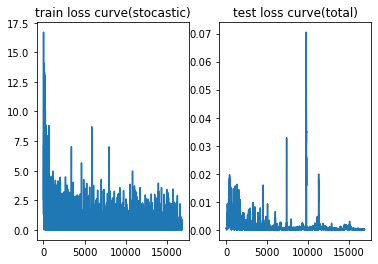

In [27]:
import matplotlib.pyplot as plt

plt.figure()

plt.subplot(1,2,1)
plt.plot(train_loss)
plt.title('train loss curve(stocastic)')

plt.subplot(1,2,2)
plt.plot(test_loss)
plt.title('test loss curve(total)')

plt.show()

In [28]:
def get_real_position(position, mean, std):
    origin_X = position[0] * std[0] + mean[0]
    origin_Y = position[1] * std[1] + mean[1]
    
    return [origin_X, origin_Y]

In [107]:
# test第一个点坐标(给的预测值是比例)
index = 42

predict_y = ball_net(test_X[index].unsqueeze(0)).squeeze().detach().numpy()
origin_y = test_Y[index].numpy()

print('preditc_y:', get_real_position(predict_y, mean_for_predict, std_for_predict))
print('origin_y:', get_real_position(origin_y, mean_for_predict, std_for_predict))

print('-------------------------------------------------------------------------------')
print('used frame num:', len(test_X[index]))
print(test_X[index])

preditc_y: [813.3569885304896, -3267.9870363371447]
origin_y: [923.5800254698115, -3455.645891834749]
-------------------------------------------------------------------------------
used frame num: 40
tensor([[ 0.2544, -0.2403,  0.6365, -0.3843, -0.9531],
        [ 0.3040, -0.2794,  0.7794, -0.5137, -0.9277],
        [ 0.3542, -0.3203,  0.9295, -0.6688, -0.9002],
        [ 0.4064, -0.3606,  1.0767, -0.8265, -0.8915],
        [ 0.4594, -0.4029,  1.2037, -0.9721, -0.8760],
        [ 0.5107, -0.4468,  1.3178, -1.1117, -0.8468],
        [ 0.5620, -0.4911,  1.4088, -1.2338, -0.8255],
        [ 0.6188, -0.5372,  1.4909, -1.3394, -0.8122],
        [ 0.6686, -0.5841,  1.5448, -1.4283, -0.7902],
        [ 0.7241, -0.6334,  1.5897, -1.5057, -0.7680],
        [ 0.7785, -0.6810,  1.6229, -1.5653, -0.7474],
        [ 0.8316, -0.7319,  1.6430, -1.6171, -0.7215],
        [ 0.8870, -0.7844,  1.6587, -1.6637, -0.6936],
        [ 0.9406, -0.8364,  1.6660, -1.7021, -0.6822],
        [ 0.9970, -0.8911,  1